In [ ]:
!pip install pytorch-accelerated

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
!pip install ipywidgets

In [ ]:
## nnAudio
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

In [ ]:
!pip install timm

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install scikit-image

In [34]:
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import config
from glob import glob

from tqdm.notebook import tqdm

import random
import math
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from pytorch_accelerated import Trainer

import timm

import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from nnAudio import features

from timm.loss import LabelSmoothingCrossEntropy
import timm.optim

from torchmetrics import MetricCollection, Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score

from evaluate_torch import get_results, evaluate_model_timestamp

# Evaluation with PSDS
from eval import do_eval 

In [35]:
# trainer class
class TrainerWithMetrics(Trainer):
    def __init__(self, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # this will be moved to the correct device automatically by the
        # MoveModulesToDeviceCallback callback, which is used by default
        self.metrics = MetricCollection(
            {
                "accuracy": Accuracy(num_classes=num_classes),
                "precision": Precision(num_classes=num_classes),
                "recall": Recall(num_classes=num_classes),
            }
        )
    
    def calculate_train_batch_loss(self, batch):
        xb, yb = batch[0], batch[1]

        model_outputs = self.model(xb)
        loss = self.loss_func(model_outputs['prediction'], yb)

        return {
            "loss": loss,
            "model_outputs": model_outputs,
            "batch_size": yb.size(0),
        }
    
    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch[0], batch[1]
            model_outputs = self.model(xb)
            val_loss = self.loss_func(model_outputs['prediction'], yb)

        batch_output = {
            "loss": val_loss,
            "model_outputs": model_outputs,
            "batch_size": yb.size(0),
        }
        preds = batch_output["model_outputs"]['prediction'].argmax(dim=-1)

        self.metrics.update(preds, batch[1])

        return batch_output

    def eval_epoch_end(self):
        metrics = self.metrics.compute()
        self.run_history.update_metric("accuracy", metrics["accuracy"].cpu())
        self.run_history.update_metric("precision", metrics["precision"].cpu())
        self.run_history.update_metric("recall", metrics["recall"].cpu())

        self.metrics.reset()

In [8]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'index':row.name, 'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate),'sound_type':row['sound_type'], 'length': row['length']})
        elif short_audio:
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
    return pd.DataFrame(audio_offsets)       

In [9]:
def get_offsets_df(df, short_audio=False):
    
    #print("^^^^ INSIDE GET OFFSET^^^^^^")
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
#     print("min_len = " +str(min_length))
#     print("step_size = " +str(config.step_size))
#     print("win_size = " +str(config.win_size))
       
    step_frac = config.step_size/config.win_size
#     print("step_frac = " +str(step_frac))
#     print("processing the dataframe...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        #print("id = " +str(row['id']))
        #print("length = " +str(row['length']))
        if row['length'] > min_length:
            #print("...length > min len... " )
            step_size = step_frac*min_length
            #print("step_size = " +str(step_size))
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
            split = int((row['length']-min_length)//step_size)
            #print("one audio file is being split into  " + str(split))
            for i in range(1, int((row['length']-min_length)//step_size)):
#                 print("appending to the list..." )
#                 print("i = " +str(i))
#                 print("index = " + str(row.name))
#                 print("id = " + str(row['id']))
#                 print("offset = " + str(int(min_length+(i*step_size)*config.rate)))
#                 print("sound_type = " + str(row['sound_type']))
#                 print('length = '+ str(row['length']))
                audio_offsets.append({'index':row.name, 'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate),'sound_type':row['sound_type'], 'length': row['length']})
                
        elif short_audio:
#             print("processing the row when audio file is shorter....")
#             print("appending to the list...")
#             print("index = " + str(row.name))
#             print("id = " + str(row['id']))
#             print("offset = " + str(0))
#             print("sound_type = " + str(row['sound_type']))
#             print('length = '+ str(row['length']))
            audio_offsets.append({'index':row.name,'id':row['id'], 'offset':0,'sound_type': row['sound_type'], 'length': row['length']})
    
    
    print("length of audio_offset = " +str(len(audio_offsets)))
    return pd.DataFrame(audio_offsets)       

In [56]:
config.data_df

'/my_data/UCB/W210/ComParE2022/data/metadata/humbugdb_zenodo_0_0_2.csv'

In [10]:
df = pd.read_csv(config.data_df)

# To be kept: please do not edit the dev set: these paths select dev set a, dev set b as described in the paper
idx_dev_a = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_dev_b = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_dev_a, idx_dev_b))
df_dev_a = df[idx_dev_a]
df_dev_b = df[idx_dev_b]


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ... 

# Assertion to check that train does NOT appear in dev:
assert len(np.where(pd.concat([df_train,df_dev_a,
                               df_dev_b]).duplicated())[0]) == 0, 'Train dataframe contains overlap with dev A, dev B'

In [11]:
print(config.NFFT, config.win_size, config.n_hop, config.step_size)
print((config.win_size * config.n_hop) / config.rate)

2048 30 512.0 10
1.92


In [12]:
# config.NFFT = 1024
# config.win_size = 360
# config.n_hop = config.NFFT//8
# config.step_size = config.win_size//3

In [13]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

In [14]:
# step min length
(config.step_size * config.n_hop) / config.rate

0.64

In [15]:
# come on feel the noise

# first get the length of all the MUSAN noises https://www.openslr.org/17/ --> data/noise
files_noise = glob('../../HumBugDB/data/noise/**/*.wav')+glob('../../HumBugDB/data/audioset/*.wav')
df_noise = pd.DataFrame([{'path': f, 'length': torchaudio.sox_effects.apply_effects_file(f, effects=[["rate", f'{config.rate}']])[0].shape[1]/config.rate} for f in tqdm(files_noise)])
# make the noise in the training data match the format
df_noise_train = df_train[(df_train['sound_type']!='mosquito')][['id','length']]
df_noise_train = df_noise_train[df_noise_train['length']>min_length].sample(frac=0.19)
df_noise_train['path'] = df_noise_train['id'].apply(lambda x: os.path.join(config.data_dir_train,f'{x}.wav'))
df_noise = pd.concat([df_noise,df_noise_train[['path','length']]],ignore_index=True)

  0%|          | 0/4012 [00:00<?, ?it/s]

In [16]:
# use audio clips shorter than min length ?
USE_SHORT_AUDIO = True
# get the frame offsets for each audio file into dataframes
audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
audio_df_test_A = get_offsets_df(df_dev_a, short_audio=True)
audio_df_test_B = get_offsets_df(df_dev_b, short_audio=True)

  0%|          | 0/8196 [00:00<?, ?it/s]

length of audio_offset = 146999


  0%|          | 0/2165 [00:00<?, ?it/s]

length of audio_offset = 15059


  0%|          | 0/157 [00:00<?, ?it/s]

length of audio_offset = 4106


In [17]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, noise_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                 ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "500"],
                ])

            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
                f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            #f = f_out.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        #if real_idx % 2 == 0 and self.audio_df.loc[real_idx]['sound_type'] == 'mosquito':
        #if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' and random.randint(0,1)==1:
        if random.randint(0,1)==2:
            sample_length = x.shape[1]/config.rate#sample_length = self.audio_df.loc[real_idx]['length']
            if len(self.noise_df[self.noise_df['length'] >= sample_length]) > 0:
                noise_path = self.noise_df[self.noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
                noise, _ = self._get_sample_(noise_path, resample=config.rate)
                
                noise_length_difference = noise.shape[1]-x.shape[1] 
                
                random_noise_offset = 0 if noise_length_difference==0 else random.randrange(0,noise_length_difference)
                noise = noise[:, random_noise_offset:random_noise_offset+x.shape[1]]

                mos_power = x.norm(p=2)
                noise_power = noise.norm(p=2)

                snr = math.exp(random.randint(2,5) / 10)
                
                scale = snr * noise_power / mos_power
                x = (scale * x + noise) / 2
        
        offset = self.audio_df.loc[real_idx]['offset']
        return (x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx)


In [18]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, noise_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [ ["remix", "1"] ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])

            #print("path = " + str(path))
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            #waveform, rate = librosa.load(path)
            
            #print("shape of waveform = " + str(waveform.shape))
            
            if waveform.shape[1] < config.rate*self.min_length:
                #print("inside processing for short filess...")
                r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
                #print(" r = " + str(r))
                f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
                #print("shape of f = " + str(f.shape))
            else:    
                #print("processing long files...")
                f = waveform[0]
                #print("shape of f = " + str(f.shape))
            mu = torch.std_mean(f)[1]
            #print("mu = " + str(mu))
            st = torch.std_mean(f)[0]
            #print("st = " + str(st))
            # clip amplitudes
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
            f = f_out.unsqueeze(0)
            #print("f_out shape = " + str(f_out.shape))
            
            
            if self.cache is not None:
                self.cache[path] = f_out
        
        
        
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        #if real_idx % 2 == 0 and self.audio_df.loc[real_idx]['sound_type'] == 'mosquito':
        #if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' and random.randint(0,1)==1:
        if random.randint(0,1)==1:
            sample_length = x.shape[1]/config.rate #sample_length = self.audio_df.loc[real_idx]['length']
            if len(self.noise_df[self.noise_df['length'] >= sample_length]) > 0:
                noise_path = self.noise_df[self.noise_df['length'] >= sample_length].sample(1).iloc[0]['path']
                #print("x shape = " + str(x.shape))
                #noise_path = self.noise_df.sample(1).iloc[0]['path']
                #print("noise_path = " + str(noise_path))
                noise, _ = self._get_sample_(noise_path, resample=config.rate)
                #print("shape of noise file = " + str(noise.shape))
                #noise_length_difference = noise.shape[1]-x.shape[1] 
                noise_length_difference = abs(noise.shape[1]-x.shape[1] )
                #print("noise_length_difference = " + str(noise_length_difference))
                
                random_noise_offset = 0 if noise_length_difference==0 else random.randrange(0,noise_length_difference)
                #print("random_noise_offset = " + str(random_noise_offset))
                noise = noise[:, random_noise_offset:random_noise_offset+x.shape[1]]
                #print("shape of noise , post offset = " + str(noise.shape))

                mos_power = x.norm(p=2)
                #print("mos_power = " + str(mos_power))
                noise_power = noise.norm(p=2)
                #print("noise_power = " + str(noise_power))
                

                snr = math.exp(random.randint(2,5) / 10)
                #print("snr =  " + str(snr))
                
                
                scale = snr * noise_power / mos_power
                
                x = (scale * x + noise) / 2
                #applying hpss
                
                
        #x_new = torch.squeeze(x).numpy()
        #print("shape of x_new =  " + str(x_new.shape))
        #D = librosa.stft(x_new)
        #H, P = librosa.decompose.hpss(D,margin = 3)
        #x = D - P
        #x = torch.tensor(librosa.istft(x))
        #print("shape of x =  " + str(x.shape))
        #x = torch.unsqueeze(x,dim = 0)
                
        offset = self.audio_df.loc[real_idx]['offset']
        return (x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx)


In [19]:
class MozTestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        if self.cache is not None and path in self.cache:
            return self.cache[path], resample
        else:
            effects = [
                ["remix", "1"]
            ]
            if resample:
                effects.extend([
                  ["rate", f'{resample}'],
                  ['gain', '-n'],
                ["highpass", "200"],
                ])
            waveform, rate = torchaudio.sox_effects.apply_effects_file(path, effects=effects)
            if waveform.shape[1] < config.rate*self.min_length:
                left_pad_amt = int((config.rate*min_length-waveform.shape[1])//2)
                left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
                right_pad_amt = int(config.rate*min_length-waveform.shape[1]-left_pad_amt)
                right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
                f = torch.cat([left_pad,waveform,right_pad],dim=1)[0]
                f = ((0.0001**0.5)*torch.randn(1, int(config.rate*min_length))+f)[0]
#                 r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
#                 f = torch.cat([waveform for _ in range(r)],dim=1)[:,:int(config.rate*self.min_length)][0]
            else:    
                f = waveform[0]
            mu = torch.std_mean(f)[1]
            st = torch.std_mean(f)[0]
            #return waveform, rate, waveform
            f_out = torch.clamp(f, min=mu-st*3, max=mu+st*3).unsqueeze(0)
#             f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out, rate

    def __getitem__(self, idx):
        real_idx = idx % len(self.audio_df)
        x, _ = self._get_sample_(os.path.join(self.data_dir,f"{self.audio_df.loc[real_idx]['id']}.wav"), resample=config.rate)
        
        
        
        offset = self.audio_df.loc[real_idx]['offset']
        return x[:,offset:int(offset+config.rate*self.min_length)], torch.tensor(1) if self.audio_df.loc[real_idx]['sound_type'] == 'mosquito' else torch.tensor(0), idx
    
    

In [20]:
# initialize empty cache
# it would be great if this was something cooler than a dictionary
audio_cache={}

In [21]:
valid_size = 0.2
shuffle = True
random_seed = 42
min_length = (config.win_size * config.n_hop) / config.rate
# needed for cache

num_workers=0
pin_memory=True

num_train = len(audio_df_train)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir_train, min_length, audio_cache)

val_dataset = MozTrainDataset(audio_df_train, df_noise, config.data_dir_train, min_length, audio_cache)

In [22]:
batch_size = 32

dataset_test_A = MozTestDataset(audio_df_test_A, config.data_dir_dev_a, min_length, audio_cache)

test_loader_A = torch.utils.data.DataLoader(
        dataset_test_A, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

dataset_test_B = MozTestDataset(audio_df_test_B, config.data_dir_dev_b, min_length, audio_cache)

test_loader_B = torch.utils.data.DataLoader(
        dataset_test_B, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

In [23]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [24]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [25]:
def evaluate_model(model, test_loader, n_samples, n_channels=3):
    with torch.no_grad():
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f'Evaluating on {device}')

        softmax = nn.Softmax(dim=1)
        
        y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 2])
        model.eval() # Important to not leak info from batch norm layers and cause other issues
        
        for n in range(n_samples):
            all_y_pred = []
            all_y = []
            for x, y, idx in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                y_pred = model(x)['prediction']
                all_y.append(y.cpu().detach())

                all_y_pred.append(y_pred.cpu().detach())

                del x
                del y
                del y_pred

            all_y_pred = torch.cat(all_y_pred)
            all_y = torch.cat(all_y)

            y_preds_all[n,:] = softmax(all_y_pred)
#             y_preds_all[n,:,1] = np.array(sigmoid(all_y_pred).squeeze())
#             y_preds_all[n,:,0] = 1-np.array(sigmoid(all_y_pred).squeeze()) # Check ordering of classes (yes/no)
            test_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
            print(test_acc)
    return y_preds_all, all_y

In [26]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300, fmax=3000, sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
#             spec = self.timeMasking(spec)
#             spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        pred = self.softmax(pred)
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [27]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [22]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=3, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=2048, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300,fmax = 1100 ,sr=8000, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
#         self.median_filter = MedianPool2d()
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        #print("spec shape after applying STFT = " + str(spec.shape))
        
              
        #spec = self.median_filter(spec)
        #print("spec shape after median filter = " + str(spec.shape))
#         spec_squee = torch.squeeze(spec,dim=3)
        #print("Post squeeze spec shape = " + str(spec_squee.shape))
        
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        #print("Post PCEN shape = " + str(spec.device))
        spec = self.norm_layer(spec)
        #print("Post norm shape = " + str(spec.shape))
        if self.training:
            spec = self.timeMasking(spec)
            #print("Post time masking shape = " + str(spec.shape))
        
            spec = self.freqMasking(spec)
            #print("Post freq masking shape = " + str(spec.shape))

        # then size for CNN model
        # and create a channel
        spec3 = spec[:,:(spec.shape[1]//3)*3,:]
        spec3 = spec3.view(spec3.shape[0],3,spec3.shape[1]//3,spec3.shape[2])
        
        x = self.sizer(spec3)
        #print("Post sizer device = " + str(spec.device))
#         x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        #print("PRED device = " + str(pred.device))
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [28]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.3, global_pool='avgmax',
                        drop_rate=0.3)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=2048, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300,fmax = 1100 ,sr=8000, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.median_filter = MedianPool2d()
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        #print("spec shape after applying STFT = " + str(spec.shape))
        
              
        spec = self.median_filter(spec)
        #print("spec shape after median filter = " + str(spec.shape))
        spec_squee = torch.squeeze(spec)
        #print("Post squeeze spec shape = " + str(spec_squee.shape))
        
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec_squee)
        #print("Post PCEN shape = " + str(spec.device))
        spec = self.norm_layer(spec)
        #print("Post norm shape = " + str(spec.shape))
        
        spec = self.timeMasking(spec)
        #print("Post time masking shape = " + str(spec.shape))
        
        spec = self.freqMasking(spec)
        #print("Post freq masking shape = " + str(spec.shape))

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        #print("Post sizer device = " + str(spec.device))
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        
        pred = self.softmax(pred)
        #print("PRED device = " + str(pred.device))
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [36]:
backbone = timm.create_model('convnext_base_384_in22ft1k',
                        pretrained=True, num_classes=2, in_chans=3, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)

INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)


In [21]:

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

In [22]:
X = next(iter(train_loader))

In [30]:
X[0].shape

torch.Size([32, 1, 15360])

In [68]:
spec_layer = features.STFT(n_fft=2048, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300,fmax = 1100 ,sr=8000, output_format="Magnitude", trainable=True)
pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
norm_layer = Normalization(mode='framewise')
sizer = VT.Resize((384,384))

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0689 seconds


In [25]:
s = spec_layer(X[0])

In [32]:
s = pcen_layer(s)

In [35]:
s = norm_layer(s)

In [64]:
s2 = s[:,:(s.shape[1]//3)*3,:]

In [ ]:
s2.view(s2.shape[0],3,s2.shape[1]//3,s2.shape[2])

In [69]:
backbone(sizer(s2.view(s2.shape[0],3,s2.shape[1]//3,s2.shape[2])))

tensor([[ 0.5654, -0.4154],
        [ 0.5571, -0.6694],
        [-0.3487,  0.3507],
        [-0.4250, -1.1014],
        [-0.6758,  0.1676],
        [-0.0469, -0.5416],
        [-0.2612, -0.0154],
        [ 0.4123, -0.0448],
        [-0.0966, -0.1458],
        [ 0.0429,  0.7341],
        [ 1.0580,  0.5964],
        [ 0.2290, -0.5579],
        [ 0.3292, -0.0656],
        [-0.4123, -0.6224],
        [-0.5096, -0.6557],
        [-0.1446, -0.5364],
        [-0.4855, -0.0354],
        [-0.1989, -0.4939],
        [-0.5526, -0.3433],
        [ 0.0924, -0.3688],
        [-0.1616, -0.4016],
        [ 0.1462, -0.1415],
        [ 0.0339,  0.3937],
        [-0.2337, -0.1771],
        [ 0.0598, -0.5879],
        [-0.8816,  0.4699],
        [ 0.5448,  0.2207],
        [ 0.1605, -0.5507],
        [-0.3995, -0.8679],
        [ 0.0784, -0.3125],
        [-0.5764, -0.0833],
        [ 0.4713, -0.5791]], grad_fn=<AddmmBackward0>)

In [39]:
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
#     im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [49]:
torch.cat([s[:,0:s.shape[1]//3,:],s[:,s.shape[1]//3:(s.shape[1]//3)*2,:]],dim=1).shape

torch.Size([32, 682, 31])

In [60]:
s2 = s[:,:341*3,:]

In [62]:
s2.view(s.shape[0],3,341,s.shape[2]).shape

torch.Size([32, 3, 341, 31])

In [54]:
s.shape[1]//3

341

In [58]:
32*3*341*31

1014816

In [59]:
341*3

1023

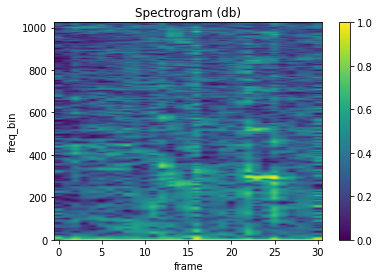

In [41]:

plot_spectrogram(s[0].cpu().detach())

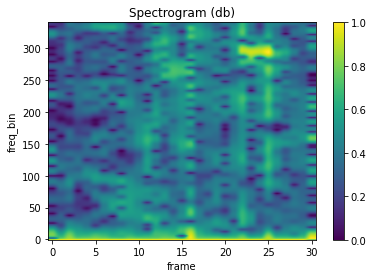

In [45]:
plot_spectrogram(s[0,0:s.shape[1]//3,:].cpu().detach())

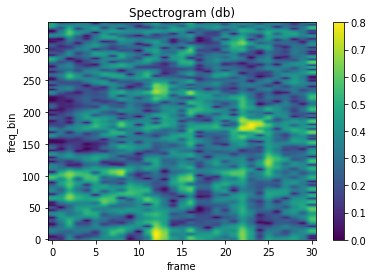

In [46]:
plot_spectrogram(s[0,s.shape[1]//3:(s.shape[1]//3)*2,:].cpu().detach())

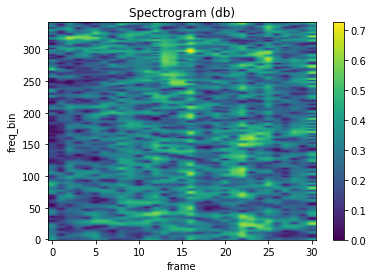

In [47]:
plot_spectrogram(s[0,(s.shape[1]//3)*2:,:].cpu().detach())

In [37]:
model = Model('convnext_base_384_in22ft1k',384)

INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0617 seconds


In [38]:
model

Model(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), 

In [29]:
from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import DEFAULT_CALLBACKS

In [36]:
# this is how you train
model = Model('convnext_base_384_in22ft1k',384)
loss_func = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = timm.optim.create_optimizer_v2(model,opt='lamb',lr=0.001,weight_decay=0.01)
num_classes =2 

trainer = TrainerWithMetrics(
    model=model, loss_func=loss_func, optimizer=optimizer, num_classes=num_classes,
    callbacks=(SaveBestModelCallback(save_path='../models/best_model.pth'),*DEFAULT_CALLBACKS,)
)


trainer.train(
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    num_epochs=12,
    per_device_batch_size=32,
)

INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0637 seconds

Starting training run

Starting epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4594/4594 [51:36<00:00,  1.48it/s]



train_loss_epoch: 0.5321051269433731


  1%|█▏                                                                                                               | 47/4594 [00:11<15:21,  4.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████████████████████████████████████████████████████████████████████████▍                                    | 3080/4594 [34:45<16:59,  1.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████


recall: 0.9187409281730652

eval_loss_epoch: 0.4305929499316901

accuracy: 0.9187409281730652

precision: 0.9187409281730652

Starting epoch 5


 22%|████████████████████████▏                                                                                       | 993/4594 [11:20<40:35,  1.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                 | 3875/4594 [13:12<02:26,  4.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████


train_loss_epoch: 0.42936579980646117


 43%|████████████████████████████████████████████████▏                                                              | 1992/4594 [06:49<08:49,  4.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4535/4594 [51:09<00:39,  1.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████


recall: 0.9340131282806396

eval_loss_epoch: 0.4179679822760049

accuracy: 0.9340131282806396

precision: 0.9340131282806396

Starting epoch 12


 50%|███████████████████████████████████████████████████████▏                                                       | 2283/4594 [25:48<26:00,  1.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:
# optional, save model
torch.save(model.state_dict(), '../models/VecNet_2020_06_15.pth')

In [41]:
torch.load('../models/best_model.pth').keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'loss'])

In [42]:
# optional, load model
model = Model('convnext_base_384_in22ft1k',384)
model.load_state_dict(torch.load('../models/best_model.pth')['model_state_dict'])
model.eval()

INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0737 seconds


Model(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), 

In [46]:
model_name = 'VecNet_2020_06_15'
# model_name = 'model_e0_2022_06_06_04_27_53'

In [47]:
feat_type='VecNet_2020_06_15'
# feat_type='model_e0_2022_06_06_04_27_53'

In [48]:
# Evaluate over dev A

In [49]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/a
!mkdir ../data/predictions/dev/a

In [50]:
# Evaluate over dev A
evaluate_model_timestamp('.wav','../data/audio/dev/a','../data/predictions/dev/a', 2, 
                         model_weights_path=f'../models/{model_name}.pth',
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=True)

Evaluating model:


INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0618 seconds
Loaded model: ../models/VecNet_2020_06_15.pth
Processing: ../data/audio/dev/a for audio format: .wav
../data/audio/dev/a 208049.wav
208049.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208049.wav
[[0.64, 2.56, '0.3833 PE: 0.9384 MI: 0.4165']]
[[0.64, 2.56, '0.3833 PE: 0.9384 MI: 0.4165']]
[[1.28, 2.56, '0.4370 PE: 0.9827 MI: 0.3108']]
[[1.92, 2.56, '0.4815 PE: 0.9990 MI: 0.1876']]
[]
[]
[]
[]
[]
[]
Processed: 208049.wav
../data/audio/dev/a 207925.wav
207925.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207925.wav
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]
[[0.0, 1.92, '0.8860 PE: 0.3306 MI: 0.3099']]


dir_out ../data/predictions/dev/a filename 207853.wav
[[0.0, 0.64, '0.1023 PE: 0.4762 MI: 0.1566']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207853.wav
../data/audio/dev/a 207967.wav
207967.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207967.wav
[[0.0, 1.92, '0.5754 PE: 0.9252 MI: 0.5316']]
[[0.0, 1.92, '0.5754 PE: 0.9252 MI: 0.5316']]
[[0.0, 1.92, '0.5754 PE: 0.9252 MI: 0.5316']]
[[0.0, 1.28, '0.6718 PE: 0.9079 MI: 0.5409']]
[[0.0, 1.28, '0.6718 PE: 0.9079 MI: 0.5409']]
[[0.0, 1.28, '0.6718 PE: 0.9079 MI: 0.5409']]
[[0.64, 1.28, '0.7116 PE: 0.8667 MI: 0.3876']]
[]
[]
[]
Processed: 207967.wav
../data/audio/dev/a 207903.wav
207903.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207903.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207903.wav
../data/audio/dev/a 208482.wav
208482.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208482.wav
[[0.0, 2.56, '0.8433 PE: 0.4537 MI: 0.3743']]
[[0.0, 2.56, '0.8433 PE: 0.4537

dir_out ../data/predictions/dev/a filename 206962.wav
[[0.64, 1.28, '0.1255 PE: 0.5449 MI: 0.0792'], [1.92, 2.56, '0.1776 PE: 0.6747 MI: 0.1269']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206962.wav
../data/audio/dev/a 208309.wav
208309.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208309.wav
[[0.0, 1.92, '0.5830 PE: 0.7670 MI: 0.4374']]
[[0.0, 1.92, '0.5830 PE: 0.7670 MI: 0.4374']]
[[0.0, 1.28, '0.7420 PE: 0.7333 MI: 0.3615']]
[[0.0, 1.28, '0.7420 PE: 0.7333 MI: 0.3615']]
[[0.0, 1.28, '0.7420 PE: 0.7333 MI: 0.3615']]
[[0.0, 0.64, '0.8931 PE: 0.4906 MI: 0.0452']]
[[0.0, 0.64, '0.8931 PE: 0.4906 MI: 0.0452']]
[[0.0, 0.64, '0.8931 PE: 0.4906 MI: 0.0452']]
[]
[]
Processed: 208309.wav
../data/audio/dev/a 207574.wav
207574.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207574.wav
[[0.0, 1.92, '0.7809 PE: 0.6090 MI: 0.5885']]
[[0.0, 1.92, '0.7809 PE: 0.6090 MI: 0.5885']]
[[0.0, 1.92, '0.7809 PE: 0.6090 MI: 0.5885']]
[[0.0, 1.92, '0.7809 PE: 0

dir_out ../data/predictions/dev/a filename 206687.wav
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.92, '0.9367 PE: 0.2488 MI: 0.1198']]
[[0.0, 1.28, '0.9969 PE: 0.0291 MI: 0.0050']]
[]
Processed: 206687.wav
../data/audio/dev/a 206992.wav
206992.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206992.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206992.wav
../data/audio/dev/a 207341.wav
207341.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207341.wav
[[0.0, 1.92, '0.9992 PE: 0.0086 MI: 0.0010']]
[[0.0, 1.92, '0.9992 PE: 0.0086 MI: 0.0010']]
[[0.0, 1.92, '0.9992 PE: 0.0086 MI: 0.0010']]
[[0.0, 1.92, '0.9992 PE: 0.0086 MI: 0.0010']]
[[0.0, 1.92, '0.9992 PE

dir_out ../data/predictions/dev/a filename 208196.wav
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 10.24, '0.9375 PE: 0.1732 MI: 0.1676']]
[[0.0, 1.92, '0.9995 PE: 0.0059 MI: 0.0009'], [3.84, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '0.9995 PE: 0.0059 MI: 0.0009'], [3.84, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '0.9995 PE: 0.0059 MI: 0.0009'], [3.84, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208196.wav
../data/audio/dev/a 206615.wav
206615.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206615.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206615.wav
../data/audio/dev/a 207499.wav
207499.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207499.wav
[[0.0, 2.56, '0.9991 PE: 0.0083 MI: 0.0014']]
[[0.0, 2.56, '0.99

dir_out ../data/predictions/dev/a filename 206587.wav
[[0.0, 2.56, '0.7500 PE: 0.6652 MI: 0.4175']]
[[0.0, 2.56, '0.7500 PE: 0.6652 MI: 0.4175']]
[[0.0, 2.56, '0.7500 PE: 0.6652 MI: 0.4175']]
[[0.0, 2.56, '0.7500 PE: 0.6652 MI: 0.4175']]
[[0.0, 2.56, '0.7500 PE: 0.6652 MI: 0.4175']]
[[0.0, 1.92, '0.8203 PE: 0.5551 MI: 0.4223']]
[[0.64, 1.92, '0.8895 PE: 0.3814 MI: 0.2273']]
[[0.64, 1.28, '0.9999 PE: 0.0009 MI: 0.0001']]
[[0.64, 1.28, '0.9999 PE: 0.0009 MI: 0.0001']]
[]
Processed: 206587.wav
../data/audio/dev/a 206874.wav
206874.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206874.wav
[[0.0, 2.56, '0.7729 PE: 0.4558 MI: 0.3592']]
[[0.0, 2.56, '0.7729 PE: 0.4558 MI: 0.3592']]
[[0.0, 2.56, '0.7729 PE: 0.4558 MI: 0.3592']]
[[0.0, 1.92, '0.9042 PE: 0.2886 MI: 0.2241']]
[[0.0, 1.92, '0.9042 PE: 0.2886 MI: 0.2241']]
[[0.0, 1.92, '0.9042 PE: 0.2886 MI: 0.2241']]
[[0.0, 1.92, '0.9042 PE: 0.2886 MI: 0.2241']]
[[0.0, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.28, '1.

dir_out ../data/predictions/dev/a filename 207650.wav
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[[0.0, 2.56, '0.9790 PE: 0.1040 MI: 0.0361']]
[]
Processed: 207650.wav
../data/audio/dev/a 206770.wav
206770.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206770.wav
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.000

dir_out ../data/predictions/dev/a filename 206980.wav
[[1.28, 4.48, '0.4360 PE: 0.9014 MI: 0.4196'], [6.4, 12.8, '0.8234 PE: 0.3942 MI: 0.2312']]
[[1.28, 4.48, '0.4360 PE: 0.9014 MI: 0.4196'], [6.4, 12.8, '0.8234 PE: 0.3942 MI: 0.2312']]
[[1.92, 3.84, '0.5480 PE: 0.9449 MI: 0.3022'], [7.04, 12.8, '0.8875 PE: 0.3485 MI: 0.2034']]
[[1.92, 3.84, '0.5480 PE: 0.9449 MI: 0.3022'], [7.04, 12.8, '0.8875 PE: 0.3485 MI: 0.2034']]
[[2.56, 3.2, '0.7255 PE: 0.8479 MI: 0.0556'], [7.04, 12.8, '0.8875 PE: 0.3485 MI: 0.2034']]
[[2.56, 3.2, '0.7255 PE: 0.8479 MI: 0.0556'], [7.68, 12.8, '0.9260 PE: 0.2694 MI: 0.1466']]
[[2.56, 3.2, '0.7255 PE: 0.8479 MI: 0.0556'], [7.68, 12.16, '0.9634 PE: 0.1763 MI: 0.0410']]
[[7.68, 12.16, '0.9634 PE: 0.1763 MI: 0.0410']]
[[8.32, 12.16, '0.9816 PE: 0.1058 MI: 0.0306']]
[]
Processed: 206980.wav
../data/audio/dev/a 208325.wav
208325.wav signal length 7.679875 1.92
dir_out ../data/predictions/dev/a filename 208325.wav
[[0.0, 7.04, '0.8473 PE: 0.4157 MI: 0.2103']]
[[0.0, 7

dir_out ../data/predictions/dev/a filename 207112.wav
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.92, '0.9164 PE: 0.3165 MI: 0.1689']]
[[0.0, 1.28, '0.9891 PE: 0.0864 MI: 0.0144']]
[[0.0, 1.28, '0.9891 PE: 0.0864 MI: 0.0144']]
[]
Processed: 207112.wav
../data/audio/dev/a 208131.wav
208131.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208131.wav
[[0.0, 1.92, '0.6758 PE: 0.6439 MI: 0.5184']]
[[0.0, 1.92, '0.6758 PE: 0.6439 MI: 0.5184']]
[[0.0, 1.92, '0.6758 PE: 0.6439 MI: 0.5184']]
[[0.0, 1.28, '0.8350 PE: 0.4956 MI: 0.3796']]
[[0.0, 1.28, '0.8350 PE: 0.4956 MI: 0.3796']]
[[0.0, 1.28, '0.8350 PE: 0.4956 MI: 0.3796']]
[[0.0, 0.64, '0.9889 PE: 0.0881 MI: 0.0052']]
[[0.0, 0.64, '0.9889 PE: 0.0881 MI: 0.0052']]
[[0.0, 0.64, '0.988

dir_out ../data/predictions/dev/a filename 207118.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207118.wav
../data/audio/dev/a 206635.wav
206635.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206635.wav
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206635.wav
../data/audio/dev/a 207679.wav
207679.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207679.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207679.wav
../data/audio/dev/a 207817.wav
207817.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 207817.wav
[[0.0, 7.04, '0.6594 PE: 0.6086 MI: 0.3

dir_out ../data/predictions/dev/a filename 208206.wav
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.0, 1.92, '0.8874 PE: 0.3197 MI: 0.3083']]
[[0.64, 1.92, '0.9978 PE: 0.0204 MI: 0.0035']]
[[0.64, 1.92, '0.9978 PE: 0.0204 MI: 0.0035']]
[[0.64, 1.92, '0.9978 PE: 0.0204 MI: 0.0035']]
[]
Processed: 208206.wav
../data/audio/dev/a 208285.wav
208285.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208285.wav
[[0.0, 1.92, '0.6888 PE: 0.6098 MI: 0.5058']]
[[0.0, 1.92, '0.6888 PE: 0.6098 MI: 0.5058']]
[[0.0, 1.92, '0.6888 PE: 0.6098 MI: 0.5058']]
[[0.0, 1.28, '0.8500 PE: 0.4407 MI: 0.3627']]
[[0.0, 1.28, '0.8500 PE: 0.4407 MI: 0.3627']]
[[0.0, 1.28, '0.8500 PE: 0.4407 MI: 0.3627']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64,

dir_out ../data/predictions/dev/a filename 208074.wav
[[0.0, 2.56, '0.6956 PE: 0.6833 MI: 0.5723']]
[[0.0, 2.56, '0.6956 PE: 0.6833 MI: 0.5723']]
[[0.0, 2.56, '0.6956 PE: 0.6833 MI: 0.5723']]
[[0.0, 1.92, '0.7970 PE: 0.5892 MI: 0.5151']]
[[0.0, 1.92, '0.7970 PE: 0.5892 MI: 0.5151']]
[[0.0, 1.92, '0.7970 PE: 0.5892 MI: 0.5151']]
[[0.64, 1.92, '0.8622 PE: 0.4247 MI: 0.3138']]
[[0.64, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.64, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 208074.wav
../data/audio/dev/a 207258.wav
207258.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207258.wav
[[0.0, 1.92, '0.5947 PE: 0.8792 MI: 0.7128']]
[[0.0, 1.92, '0.5947 PE: 0.8792 MI: 0.7128']]
[[0.0, 1.92, '0.5947 PE: 0.8792 MI: 0.7128']]
[[0.0, 1.28, '0.7180 PE: 0.8527 MI: 0.6466']]
[[0.0, 1.28, '0.7180 PE: 0.8527 MI: 0.6466']]
[[0.0, 1.28, '0.7180 PE: 0.8527 MI: 0.6466']]
[[0.0, 0.64, '0.7571 PE: 0.7999 MI: 0.4948']]
[]
[]
[]
Processed: 207258.wav
../data/audio/dev/a 207498.wav


dir_out ../data/predictions/dev/a filename 208697.wav
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 7.04, '0.9793 PE: 0.0707 MI: 0.0428']]
[[0.0, 6.4, '1.0000 PE: 0.0004 MI: 0.0000']]
[[0.0, 6.4, '1.0000 PE: 0.0004 MI: 0.0000']]
[]
Processed: 208697.wav
../data/audio/dev/a 208405.wav
208405.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208405.wav
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0

dir_out ../data/predictions/dev/a filename 207851.wav
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.64, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 207851.wav
../data/audio/dev/a 207383.wav
207383.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207383.wav
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.0, 1.92, '0.9405 PE: 0.2308 MI: 0.1093']]
[[0.64, 1.92

dir_out ../data/predictions/dev/a filename 206699.wav
[[0.64, 4.48, '0.5120 PE: 0.7952 MI: 0.3792'], [8.32, 12.16, '0.6886 PE: 0.6146 MI: 0.4952']]
[[0.64, 3.84, '0.5886 PE: 0.8433 MI: 0.4083'], [8.32, 12.16, '0.6886 PE: 0.6146 MI: 0.4952']]
[[0.64, 3.84, '0.5886 PE: 0.8433 MI: 0.4083'], [8.32, 12.16, '0.6886 PE: 0.6146 MI: 0.4952']]
[[1.28, 3.2, '0.7471 PE: 0.7825 MI: 0.3509'], [8.96, 11.52, '0.8494 PE: 0.4479 MI: 0.3555']]
[[1.28, 3.2, '0.7471 PE: 0.7825 MI: 0.3509'], [8.96, 11.52, '0.8494 PE: 0.4479 MI: 0.3555']]
[[1.28, 3.2, '0.7471 PE: 0.7825 MI: 0.3509'], [8.96, 11.52, '0.8494 PE: 0.4479 MI: 0.3555']]
[[1.92, 2.56, '0.8737 PE: 0.5473 MI: 0.1373'], [9.6, 11.52, '0.9037 PE: 0.2981 MI: 0.2234']]
[[1.92, 2.56, '0.8737 PE: 0.5473 MI: 0.1373'], [9.6, 10.88, '0.9984 PE: 0.0156 MI: 0.0025']]
[[9.6, 10.88, '0.9984 PE: 0.0156 MI: 0.0025']]
[]
Processed: 206699.wav
../data/audio/dev/a 207599.wav
207599.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207599.wav
[[0

dir_out ../data/predictions/dev/a filename 206808.wav
[[0.0, 2.56, '0.7761 PE: 0.4768 MI: 0.4020']]
[[0.0, 2.56, '0.7761 PE: 0.4768 MI: 0.4020']]
[[0.0, 2.56, '0.7761 PE: 0.4768 MI: 0.4020']]
[[0.0, 2.56, '0.7761 PE: 0.4768 MI: 0.4020']]
[[0.0, 1.92, '0.8889 PE: 0.3062 MI: 0.3061']]
[[0.0, 1.92, '0.8889 PE: 0.3062 MI: 0.3061']]
[[0.0, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 206808.wav
../data/audio/dev/a 206927.wav
206927.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206927.wav
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0007 MI: 0.0000']]
[[0.0, 1.92, '1

dir_out ../data/predictions/dev/a filename 208192.wav
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[]
Processed: 208192.wav
../data/audio/dev/a 206694.wav
206694.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 206694.wav
[[0.0, 3.84, '0.7605 PE: 0.4312 MI: 0.2271'], [4.48, 5.12, '0.1529 PE: 0.6170 MI: 0.2851']]
[[0.0, 3.84, '0.7605 PE: 0.4312 MI: 0.2271']]
[[0.0, 3.2, '0.8721 PE: 0.3722 MI: 0.1917']]
[[0.0, 3.2, '0.8721 PE: 0.3722 MI: 0.1917']]
[[0.0, 3.2, '0.8721 PE: 0.3722 MI: 0.1917']]
[[0.0, 2.56, '0.9563 PE: 0.2161 MI: 0.0713']]
[[0.0, 2.56, '0.9563 PE: 0.2161 MI: 0.0713']]
[[0.0, 2.56, '0.9563 P

dir_out ../data/predictions/dev/a filename 208385.wav
[[0.0, 4.48, '0.8571 PE: 0.2625 MI: 0.2624']]
[[0.0, 4.48, '0.8571 PE: 0.2625 MI: 0.2624']]
[[0.0, 4.48, '0.8571 PE: 0.2625 MI: 0.2624']]
[[0.0, 3.84, '0.9444 PE: 0.1532 MI: 0.1531']]
[[0.0, 3.84, '0.9444 PE: 0.1532 MI: 0.1531']]
[[0.0, 3.84, '0.9444 PE: 0.1532 MI: 0.1531']]
[[0.0, 3.2, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 3.2, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 3.2, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 208385.wav
../data/audio/dev/a 208213.wav
208213.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208213.wav
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 2.56, '0.9029 PE: 0.2813 MI: 0.2127']]
[[0.0, 1.92, '0.9908 PE: 0.0607 MI: 0.0149']]
[[0.0, 1.92, '0.9908 PE: 0.0607 MI: 0.0149']]
[[0.0, 1.92, '0.9908 P

dir_out ../data/predictions/dev/a filename 207805.wav
[[0.0, 0.64, '0.2751 PE: 0.8487 MI: 0.6259']]
[[0.0, 0.64, '0.2751 PE: 0.8487 MI: 0.6259']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207805.wav
../data/audio/dev/a 207993.wav
207993.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207993.wav
[[0.0, 2.56, '0.7457 PE: 0.5369 MI: 0.3147']]
[[0.0, 2.56, '0.7457 PE: 0.5369 MI: 0.3147']]
[[0.0, 2.56, '0.7457 PE: 0.5369 MI: 0.3147']]
[[0.0, 1.92, '0.8663 PE: 0.3957 MI: 0.2579']]
[[0.0, 1.92, '0.8663 PE: 0.3957 MI: 0.2579']]
[[0.0, 1.92, '0.8663 PE: 0.3957 MI: 0.2579']]
[[0.0, 1.28, '0.9809 PE: 0.1210 MI: 0.0270']]
[[0.0, 1.28, '0.9809 PE: 0.1210 MI: 0.0270']]
[[0.0, 1.28, '0.9809 PE: 0.1210 MI: 0.0270']]
[]
Processed: 207993.wav
../data/audio/dev/a 207129.wav
207129.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207129.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207129.wav
../data/audio/dev/a 207013.wav
207013.wav signal length 2.559875 1.92
dir_out

207584.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207584.wav
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.92, '0.8893 PE: 0.3057 MI: 0.3020']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207584.wav
../data/audio/dev/a 208451.wav
208451.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208451.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208451.wav
../data/audio/dev/a 208137.wav
208137.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208137.wav
[[0.0, 2.56, '0.6450 PE: 0.5777 MI: 0.3276']]
[[0.0, 1.92, '0.7953 PE: 0.5337 MI: 0.3092']]
[[0.0, 1.92, '0.7953 PE: 0.5337 MI: 0.3092']]
[[0.0, 1.92, '0.7953 PE: 0.5337 MI

dir_out ../data/predictions/dev/a filename 208143.wav
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 2.56, '0.9401 PE: 0.2031 MI: 0.1214']]
[[0.0, 1.92, '0.9993 PE: 0.0072 MI: 0.0011']]
[[0.0, 1.92, '0.9993 PE: 0.0072 MI: 0.0011']]
[]
Processed: 208143.wav
../data/audio/dev/a 206727.wav
206727.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206727.wav
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 2.56, '0.9068 PE: 0.2982 MI: 0.2272']]
[[0.0, 1.92, '0.9848 PE: 0.0936 MI: 0.0250']]
[[0.0, 1.92, '0.9848 PE: 0.0936 MI: 0.0250']]
[[0.0, 1.92, '0.984

dir_out ../data/predictions/dev/a filename 207715.wav
[[0.0, 2.56, '0.6682 PE: 0.6042 MI: 0.3058']]
[[0.0, 2.56, '0.6682 PE: 0.6042 MI: 0.3058']]
[[0.64, 2.56, '0.8120 PE: 0.5423 MI: 0.2634']]
[[0.64, 2.56, '0.8120 PE: 0.5423 MI: 0.2634']]
[[0.64, 2.56, '0.8120 PE: 0.5423 MI: 0.2634']]
[[1.28, 2.56, '0.9329 PE: 0.3206 MI: 0.0800']]
[[1.28, 2.56, '0.9329 PE: 0.3206 MI: 0.0800']]
[[1.28, 2.56, '0.9329 PE: 0.3206 MI: 0.0800']]
[[1.92, 2.56, '0.9844 PE: 0.1160 MI: 0.0167']]
[]
Processed: 207715.wav
../data/audio/dev/a 207910.wav
207910.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207910.wav
[[0.0, 1.92, '0.6998 PE: 0.6570 MI: 0.3503']]
[[0.0, 1.92, '0.6998 PE: 0.6570 MI: 0.3503']]
[[0.0, 1.92, '0.6998 PE: 0.6570 MI: 0.3503']]
[[0.0, 1.28, '0.8516 PE: 0.5012 MI: 0.2491']]
[[0.0, 1.28, '0.8516 PE: 0.5012 MI: 0.2491']]
[[0.0, 1.28, '0.8516 PE: 0.5012 MI: 0.2491']]
[[0.0, 1.28, '0.8516 PE: 0.5012 MI: 0.2491']]
[[0.0, 0.64, '0.9776 PE: 0.1548 MI: 0.0362']]
[[0.0, 0

dir_out ../data/predictions/dev/a filename 206941.wav
[[0.0, 15.36, '0.7976 PE: 0.4207 MI: 0.2770']]
[[0.0, 15.36, '0.7976 PE: 0.4207 MI: 0.2770']]
[[0.0, 15.36, '0.7976 PE: 0.4207 MI: 0.2770']]
[[0.0, 2.56, '0.9156 PE: 0.2950 MI: 0.1035'], [3.2, 6.4, '0.6550 PE: 0.8321 MI: 0.5517'], [8.32, 15.36, '0.9701 PE: 0.0833 MI: 0.0799']]
[[0.0, 2.56, '0.9156 PE: 0.2950 MI: 0.1035'], [3.84, 6.4, '0.7110 PE: 0.7935 MI: 0.5656'], [8.32, 15.36, '0.9701 PE: 0.0833 MI: 0.0799']]
[[0.0, 2.56, '0.9156 PE: 0.2950 MI: 0.1035'], [3.84, 6.4, '0.7110 PE: 0.7935 MI: 0.5656'], [8.32, 15.36, '0.9701 PE: 0.0833 MI: 0.0799']]
[[0.0, 2.56, '0.9156 PE: 0.2950 MI: 0.1035'], [4.48, 5.12, '0.9372 PE: 0.3385 MI: 0.0194'], [8.96, 15.36, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '0.9803 PE: 0.1089 MI: 0.0321'], [4.48, 5.12, '0.9372 PE: 0.3385 MI: 0.0194'], [8.96, 15.36, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '0.9803 PE: 0.1089 MI: 0.0321'], [4.48, 5.12, '0.9372 PE: 0.3385 MI: 0.0194'], [8.96, 15.36, '1.0000 

dir_out ../data/predictions/dev/a filename 207246.wav
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 2.56, '0.9166 PE: 0.2298 MI: 0.2295']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[]
Processed: 207246.wav
../data/audio/dev/a 207592.wav
207592.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207592.wav
[[0.0, 2.56, '0.8596 PE: 0.3761 MI: 0.2215']]
[[0.0, 2.56, '0.8596 PE: 0.3761 MI: 0.2215']]
[[0.0, 2.56, '0.8596 PE: 0.3761 MI: 0.2215']]
[[0.0, 2.56, '0.8596 PE: 0.3761 MI: 0.2215']]
[[0.0, 2.56, '0.8596 PE: 0.3761 MI: 0.2215']]
[[0.64, 2.56, '0.9620 PE: 0.1707 MI: 0.0677']]
[[0.64, 2.56, '0.9620 PE: 0.1707 MI: 0.0677']]
[[0.64, 2.56, '0.9620 PE: 0.1707 MI: 0.0677']]
[[1.28, 2.56, '1

dir_out ../data/predictions/dev/a filename 206955.wav
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.0, 2.56, '0.9557 PE: 0.1753 MI: 0.0845']]
[[0.64, 2.56, '0.9988 PE: 0.0116 MI: 0.0015']]
[]
Processed: 206955.wav
../data/audio/dev/a 208582.wav
208582.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208582.wav
[[0.0, 1.92, '0.6667 PE: 0.6122 MI: 0.6121']]
[[0.0, 1.92, '0.6667 PE: 0.6122 MI: 0.6121']]
[[0.0, 1.92, '0.6667 PE: 0.6122 MI: 0.6121']]
[[0.0, 1.28, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 1.28, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 1.28, '0.8333 PE: 0.4592 MI: 0.4591']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '

dir_out ../data/predictions/dev/a filename 207297.wav
[[0.0, 2.56, '0.7416 PE: 0.4811 MI: 0.4281']]
[[0.0, 2.56, '0.7416 PE: 0.4811 MI: 0.4281']]
[[0.0, 2.56, '0.7416 PE: 0.4811 MI: 0.4281']]
[[0.0, 1.92, '0.8814 PE: 0.3392 MI: 0.2921']]
[[0.0, 1.92, '0.8814 PE: 0.3392 MI: 0.2921']]
[[0.0, 1.92, '0.8814 PE: 0.3392 MI: 0.2921']]
[[0.0, 1.28, '0.9944 PE: 0.0443 MI: 0.0090']]
[[0.0, 1.28, '0.9944 PE: 0.0443 MI: 0.0090']]
[[0.0, 1.28, '0.9944 PE: 0.0443 MI: 0.0090']]
[]
Processed: 207297.wav
../data/audio/dev/a 208524.wav
208524.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208524.wav
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1

dir_out ../data/predictions/dev/a filename 208193.wav
[[0.0, 1.92, '0.7092 PE: 0.6034 MI: 0.4466']]
[[0.0, 1.92, '0.7092 PE: 0.6034 MI: 0.4466']]
[[0.0, 1.92, '0.7092 PE: 0.6034 MI: 0.4466']]
[[0.0, 1.28, '0.8652 PE: 0.4205 MI: 0.3032']]
[[0.0, 1.28, '0.8652 PE: 0.4205 MI: 0.3032']]
[[0.0, 1.28, '0.8652 PE: 0.4205 MI: 0.3032']]
[[0.0, 1.28, '0.8652 PE: 0.4205 MI: 0.3032']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208193.wav
../data/audio/dev/a 208324.wav
208324.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208324.wav
[[0.0, 5.12, '0.8454 PE: 0.3282 MI: 0.2011']]
[[0.0, 5.12, '0.8454 PE: 0.3282 MI: 0.2011']]
[[0.0, 5.12, '0.8454 PE: 0.3282 MI: 0.2011']]
[[0.0, 4.48, '0.9228 PE: 0.2485 MI: 0.1476']]
[[0.0, 4.48, '0.9228 PE: 0.2485 MI: 0.1476']]
[[0.0, 4.48, '0.9228 PE: 0.2485 MI: 0.1476']]
[[0.0, 3.84, '0.9737 PE: 0.1299 MI: 0.0457']]
[[0.0, 3.84, '0.9737 PE: 0.1299 MI: 0.0457']]
[[0.64, 3.84, '0.99

dir_out ../data/predictions/dev/a filename 207812.wav
[[0.0, 2.56, '0.6821 PE: 0.6701 MI: 0.6123']]
[[0.0, 2.56, '0.6821 PE: 0.6701 MI: 0.6123']]
[[0.0, 2.56, '0.6821 PE: 0.6701 MI: 0.6123']]
[[0.0, 1.92, '0.7984 PE: 0.5874 MI: 0.5104']]
[[0.0, 1.92, '0.7984 PE: 0.5874 MI: 0.5104']]
[[0.0, 1.92, '0.7984 PE: 0.5874 MI: 0.5104']]
[[0.0, 1.28, '0.8642 PE: 0.4219 MI: 0.3065']]
[[0.64, 1.28, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.64, 1.28, '1.0000 PE: 0.0002 MI: 0.0000']]
[]
Processed: 207812.wav
../data/audio/dev/a 207905.wav
207905.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207905.wav
[[0.0, 1.28, '0.4990 PE: 0.9335 MI: 0.7601']]
[[0.0, 1.28, '0.4990 PE: 0.9335 MI: 0.7601']]
[[0.0, 1.28, '0.4990 PE: 0.9335 MI: 0.7601']]
[[0.0, 0.64, '0.6496 PE: 0.9344 MI: 0.8370']]
[[0.0, 0.64, '0.6496 PE: 0.9344 MI: 0.8370']]
[[0.0, 0.64, '0.6496 PE: 0.9344 MI: 0.8370']]
[]
[]
[]
[]
Processed: 207905.wav
../data/audio/dev/a 208125.wav
208125.wav signal length 5.119875 1.92
d

dir_out ../data/predictions/dev/a filename 207947.wav
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.0, 1.92, '0.9179 PE: 0.2704 MI: 0.1759']]
[[0.64, 1.92, '0.9997 PE: 0.0035 MI: 0.0002']]
[[0.64, 1.92, '0.9997 PE: 0.0035 MI: 0.0002']]
[]
Processed: 207947.wav
../data/audio/dev/a 207777.wav
207777.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207777.wav
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9947 PE: 0.0369 MI: 0.0085']]
[[0.0, 2.56, '0.9

dir_out ../data/predictions/dev/a filename 207582.wav
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 10.24, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207582.wav
../data/audio/dev/a 208618.wav
208618.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208618.wav
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.0, 1.92, '0.8947 PE: 0.2999 MI: 0.2669']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.

dir_out ../data/predictions/dev/a filename 207681.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207681.wav
../data/audio/dev/a 208113.wav
208113.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208113.wav
[[0.0, 2.56, '0.5966 PE: 0.8227 MI: 0.5020']]
[[0.0, 2.56, '0.5966 PE: 0.8227 MI: 0.5020']]
[[0.0, 1.92, '0.6970 PE: 0.8051 MI: 0.4369']]
[[0.0, 1.92, '0.6970 PE: 0.8051 MI: 0.4369']]
[[0.0, 1.92, '0.6970 PE: 0.8051 MI: 0.4369']]
[[0.0, 1.28, '0.7526 PE: 0.7184 MI: 0.3435']]
[[0.64, 1.28, '0.9000 PE: 0.4689 MI: 0.0080']]
[[0.64, 1.28, '0.9000 PE: 0.4689 MI: 0.0080']]
[[0.64, 1.28, '0.9000 PE: 0.4689 MI: 0.0080']]
[]
Processed: 208113.wav
../data/audio/dev/a 207050.wav
207050.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207050.wav
[[0.0, 2.56, '0.7226 PE: 0.5135 MI: 0.3888']]
[[0.0, 2.56, '0.7226 PE: 0.5135 MI: 0.3888']]
[[0.0, 1.92, '0.8645 PE: 0.3922 MI: 0.2814']]
[[0.0, 1.92, '0.8645 PE: 0.3922 MI: 0.2814']]
[[0.0, 1.92, '0.8645 PE: 0.3

dir_out ../data/predictions/dev/a filename 206600.wav
[[0.0, 0.64, '0.3167 PE: 0.9008 MI: 0.7874']]
[[0.0, 0.64, '0.3167 PE: 0.9008 MI: 0.7874']]
[[0.0, 0.64, '0.3167 PE: 0.9008 MI: 0.7874']]
[]
[]
[]
[]
[]
[]
[]
Processed: 206600.wav
../data/audio/dev/a 207330.wav
207330.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207330.wav
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 207330.wav
../data/audio/dev/a 207801.wav
207801.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207801.wav
[[0.0, 2.56, '0.9995 PE: 0.0055 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0055 MI: 0.00

dir_out ../data/predictions/dev/a filename 208707.wav
[[0.0, 2.56, '0.7493 PE: 0.4618 MI: 0.4551']]
[[0.0, 2.56, '0.7493 PE: 0.4618 MI: 0.4551']]
[[0.0, 2.56, '0.7493 PE: 0.4618 MI: 0.4551']]
[[0.0, 1.92, '0.8883 PE: 0.3100 MI: 0.3039']]
[[0.0, 1.92, '0.8883 PE: 0.3100 MI: 0.3039']]
[[0.0, 1.92, '0.8883 PE: 0.3100 MI: 0.3039']]
[[0.0, 1.28, '0.9995 PE: 0.0054 MI: 0.0007']]
[[0.0, 1.28, '0.9995 PE: 0.0054 MI: 0.0007']]
[[0.0, 1.28, '0.9995 PE: 0.0054 MI: 0.0007']]
[]
Processed: 208707.wav
../data/audio/dev/a 208564.wav
208564.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208564.wav
[[0.0, 1.92, '0.6476 PE: 0.6627 MI: 0.5345']]
[[0.0, 1.92, '0.6476 PE: 0.6627 MI: 0.5345']]
[[0.0, 1.92, '0.6476 PE: 0.6627 MI: 0.5345']]
[[0.64, 1.92, '0.8122 PE: 0.5428 MI: 0.4293']]
[[0.64, 1.92, '0.8122 PE: 0.5428 MI: 0.4293']]
[[0.64, 1.92, '0.8122 PE: 0.5428 MI: 0.4293']]
[[1.28, 1.92, '0.9789 PE: 0.1476 MI: 0.0341']]
[[1.28, 1.92, '0.9789 PE: 0.1476 MI: 0.0341']]
[[1.28, 1.

dir_out ../data/predictions/dev/a filename 208672.wav
[[0.64, 4.48, '0.8332 PE: 0.3068 MI: 0.3050']]
[[0.64, 4.48, '0.8332 PE: 0.3068 MI: 0.3050']]
[[0.64, 4.48, '0.8332 PE: 0.3068 MI: 0.3050']]
[[1.28, 4.48, '0.9332 PE: 0.1845 MI: 0.1831']]
[[1.28, 4.48, '0.9332 PE: 0.1845 MI: 0.1831']]
[[1.28, 4.48, '0.9332 PE: 0.1845 MI: 0.1831']]
[[1.92, 4.48, '0.9999 PE: 0.0010 MI: 0.0001']]
[[1.92, 4.48, '0.9999 PE: 0.0010 MI: 0.0001']]
[[1.92, 4.48, '0.9999 PE: 0.0010 MI: 0.0001']]
[]
Processed: 208672.wav
../data/audio/dev/a 208499.wav
208499.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208499.wav
[[0.0, 2.56, '0.7116 PE: 0.5279 MI: 0.3729']]
[[0.0, 2.56, '0.7116 PE: 0.5279 MI: 0.3729']]
[[0.0, 1.92, '0.8548 PE: 0.4177 MI: 0.2801']]
[[0.0, 1.92, '0.8548 PE: 0.4177 MI: 0.2801']]
[[0.0, 1.92, '0.8548 PE: 0.4177 MI: 0.2801']]
[[0.0, 1.92, '0.8548 PE: 0.4177 MI: 0.2801']]
[[0.0, 1.28, '0.9744 PE: 0.1460 MI: 0.0426']]
[[0.0, 1.28, '0.9744 PE: 0.1460 MI: 0.0426']]
[[0.0, 1.2

dir_out ../data/predictions/dev/a filename 207516.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207516.wav
../data/audio/dev/a 208184.wav
208184.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208184.wav
[[0.0, 1.92, '0.6792 PE: 0.6114 MI: 0.5421']]
[[0.0, 1.92, '0.6792 PE: 0.6114 MI: 0.5421']]
[[0.0, 1.92, '0.6792 PE: 0.6114 MI: 0.5421']]
[[0.0, 1.28, '0.8427 PE: 0.4492 MI: 0.3972']]
[[0.0, 1.28, '0.8427 PE: 0.4492 MI: 0.3972']]
[[0.0, 1.28, '0.8427 PE: 0.4492 MI: 0.3972']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208184.wav
../data/audio/dev/a 208348.wav
208348.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208348.wav
[[0.0, 4.48, '0.8516 PE: 0.2765 MI: 0.2426']]
[[0.0, 4.48, '0.8516 PE: 0.2765 MI: 0.2426']]
[[0.0, 4.48, '0.8516 PE: 0.2765 MI: 0.2426']]
[[0.0, 3.84, '0.9401 PE: 0.1718 MI: 0.1454']]
[[0.0, 3.84, '0.9401 PE: 0.

dir_out ../data/predictions/dev/a filename 208088.wav
[[0.0, 1.92, '0.7429 PE: 0.5838 MI: 0.3767']]
[[0.0, 1.92, '0.7429 PE: 0.5838 MI: 0.3767']]
[[0.0, 1.92, '0.7429 PE: 0.5838 MI: 0.3767']]
[[0.0, 1.92, '0.7429 PE: 0.5838 MI: 0.3767']]
[[0.0, 1.28, '0.8905 PE: 0.3796 MI: 0.2241']]
[[0.0, 1.28, '0.8905 PE: 0.3796 MI: 0.2241']]
[[0.0, 1.28, '0.8905 PE: 0.3796 MI: 0.2241']]
[[0.0, 0.64, '0.9999 PE: 0.0010 MI: 0.0001']]
[[0.0, 0.64, '0.9999 PE: 0.0010 MI: 0.0001']]
[]
Processed: 208088.wav
../data/audio/dev/a 206655.wav
206655.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206655.wav
[[0.0, 2.56, '0.6825 PE: 0.8601 MI: 0.2252']]
[[0.0, 2.56, '0.6825 PE: 0.8601 MI: 0.2252']]
[[0.0, 2.56, '0.6825 PE: 0.8601 MI: 0.2252']]
[[0.0, 2.56, '0.6825 PE: 0.8601 MI: 0.2252']]
[[0.0, 2.56, '0.6825 PE: 0.8601 MI: 0.2252']]
[[0.64, 1.92, '0.7866 PE: 0.7391 MI: 0.0530']]
[[0.64, 1.92, '0.7866 PE: 0.7391 MI: 0.0530']]
[[1.28, 1.92, '0.8318 PE: 0.6536 MI: 0.1055']]
[]
[]
Processed:

dir_out ../data/predictions/dev/a filename 208681.wav
[[0.64, 7.68, '0.8781 PE: 0.2542 MI: 0.2485']]
[[0.64, 7.68, '0.8781 PE: 0.2542 MI: 0.2485']]
[[0.64, 7.68, '0.8781 PE: 0.2542 MI: 0.2485']]
[[1.28, 7.68, '0.9325 PE: 0.1877 MI: 0.1816']]
[[1.28, 7.68, '0.9325 PE: 0.1877 MI: 0.1816']]
[[1.28, 7.68, '0.9325 PE: 0.1877 MI: 0.1816']]
[[1.92, 7.04, '0.9995 PE: 0.0046 MI: 0.0008']]
[[1.92, 7.04, '0.9995 PE: 0.0046 MI: 0.0008']]
[[1.92, 7.04, '0.9995 PE: 0.0046 MI: 0.0008']]
[]
Processed: 208681.wav
../data/audio/dev/a 206817.wav
206817.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206817.wav
[[0.0, 2.56, '0.7838 PE: 0.6231 MI: 0.3665']]
[[0.0, 2.56, '0.7838 PE: 0.6231 MI: 0.3665']]
[[0.0, 2.56, '0.7838 PE: 0.6231 MI: 0.3665']]
[[0.0, 2.56, '0.7838 PE: 0.6231 MI: 0.3665']]
[[0.0, 2.56, '0.7838 PE: 0.6231 MI: 0.3665']]
[[0.64, 2.56, '0.8524 PE: 0.5034 MI: 0.2963']]
[[0.64, 1.92, '0.9388 PE: 0.3027 MI: 0.1069']]
[[0.64, 1.92, '0.9388 PE: 0.3027 MI: 0.1069']]
[[1.28,

dir_out ../data/predictions/dev/a filename 208169.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208169.wav
../data/audio/dev/a 208438.wav
208438.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208438.wav
[[0.0, 2.56, '0.6115 PE: 0.6890 MI: 0.3470']]
[[0.0, 2.56, '0.6115 PE: 0.6890 MI: 0.3470']]
[[0.0, 1.92, '0.7206 PE: 0.6316 MI: 0.4329']]
[[0.0, 1.92, '0.7206 PE: 0.6316 MI: 0.4329']]
[[0.0, 1.28, '0.8469 PE: 0.4489 MI: 0.3729']]
[[0.0, 1.28, '0.8469 PE: 0.4489 MI: 0.3729']]
[[0.0, 0.64, '0.9991 PE: 0.0102 MI: 0.0006']]
[[0.0, 0.64, '0.9991 PE: 0.0102 MI: 0.0006']]
[[0.0, 0.64, '0.9991 PE: 0.0102 MI: 0.0006']]
[]
Processed: 208438.wav
../data/audio/dev/a 208346.wav
208346.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208346.wav
[[0.0, 1.92, '0.6784 PE: 0.6141 MI: 0.5414']]
[[0.0, 1.92, '0.6784 PE: 0.6141 MI: 0.5414']]
[[0.0, 1.92, '0.6784 PE: 0.6141 MI: 0.5414']]
[[0.64, 1.92, '0.8402 PE: 0.4520 MI: 0.4108']]
[[0.64, 1.92, '0.8402 PE: 

dir_out ../data/predictions/dev/a filename 207291.wav
[[0.64, 2.56, '0.6542 PE: 0.7032 MI: 0.3702']]
[[0.64, 2.56, '0.6542 PE: 0.7032 MI: 0.3702']]
[[0.64, 2.56, '0.6542 PE: 0.7032 MI: 0.3702']]
[[1.28, 2.56, '0.8122 PE: 0.5933 MI: 0.2928']]
[[1.28, 2.56, '0.8122 PE: 0.5933 MI: 0.2928']]
[[1.28, 2.56, '0.8122 PE: 0.5933 MI: 0.2928']]
[[1.92, 2.56, '0.9531 PE: 0.2730 MI: 0.0707']]
[[1.92, 2.56, '0.9531 PE: 0.2730 MI: 0.0707']]
[[1.92, 2.56, '0.9531 PE: 0.2730 MI: 0.0707']]
[]
Processed: 207291.wav
../data/audio/dev/a 207966.wav
207966.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207966.wav
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.5

dir_out ../data/predictions/dev/a filename 206968.wav
[[1.28, 2.56, '0.3088 PE: 0.8134 MI: 0.3617']]
[[1.92, 2.56, '0.4587 PE: 0.9951 MI: 0.6219']]
[[1.92, 2.56, '0.4587 PE: 0.9951 MI: 0.6219']]
[[1.92, 2.56, '0.4587 PE: 0.9951 MI: 0.6219']]
[]
[]
[]
[]
[]
[]
Processed: 206968.wav
../data/audio/dev/a 207762.wav
207762.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207762.wav
[[0.0, 1.92, '0.6342 PE: 0.7013 MI: 0.4888']]
[[0.0, 1.92, '0.6342 PE: 0.7013 MI: 0.4888']]
[[0.0, 1.92, '0.6342 PE: 0.7013 MI: 0.4888']]
[[0.0, 1.28, '0.7967 PE: 0.6057 MI: 0.3768']]
[[0.0, 1.28, '0.7967 PE: 0.6057 MI: 0.3768']]
[[0.0, 1.28, '0.7967 PE: 0.6057 MI: 0.3768']]
[[0.0, 0.64, '0.9542 PE: 0.2681 MI: 0.0176']]
[[0.0, 0.64, '0.9542 PE: 0.2681 MI: 0.0176']]
[[0.0, 0.64, '0.9542 PE: 0.2681 MI: 0.0176']]
[]
Processed: 207762.wav
../data/audio/dev/a 207885.wav
207885.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207885.wav
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0

dir_out ../data/predictions/dev/a filename 206723.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206723.wav
../data/audio/dev/a 207935.wav
207935.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207935.wav
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.92, '0.8813 PE: 0.3446 MI: 0.2940']]
[[0.0, 1.28, '0.9937 PE: 0.0528 MI: 0.0100']]
[[0.0, 1.28, '0.9937 PE: 0.0528 MI: 0.0100']]
[[0.0, 1.28, '0.9937 PE: 0.0528 MI: 0.0100']]
[]
Processed: 207935.wav
../data/audio/dev/a 208412.wav
208412.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208412.wav
[[0.0, 2.56, '0.8483 PE: 0.3935 MI: 0.2305']]
[[0.0, 2.56, '0.8483 PE: 0.3935 MI: 0.2305']]
[[0.0, 2.56, '0.8483 PE: 0.3935 MI: 0.2305']]
[[0.0, 2.56, '0.8483 PE: 0.3935 MI: 0.2305']]
[[0.0, 2.56, '0.8483 PE: 0.

dir_out ../data/predictions/dev/a filename 207490.wav
[[0.0, 1.92, '0.6658 PE: 0.6156 MI: 0.6068']]
[[0.0, 1.92, '0.6658 PE: 0.6156 MI: 0.6068']]
[[0.0, 1.92, '0.6658 PE: 0.6156 MI: 0.6068']]
[[0.0, 1.28, '0.8325 PE: 0.4646 MI: 0.4559']]
[[0.0, 1.28, '0.8325 PE: 0.4646 MI: 0.4559']]
[[0.0, 1.28, '0.8325 PE: 0.4646 MI: 0.4559']]
[[0.0, 0.64, '0.9991 PE: 0.0101 MI: 0.0014']]
[[0.0, 0.64, '0.9991 PE: 0.0101 MI: 0.0014']]
[[0.0, 0.64, '0.9991 PE: 0.0101 MI: 0.0014']]
[]
Processed: 207490.wav
../data/audio/dev/a 207789.wav
207789.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207789.wav
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 5.12, '0.9582 PE: 0.1162 MI: 0.1128']]
[[0.0, 4.48, '0.9999 PE: 0.0016 MI: 0.0002']]
[[0.0, 4.48, '0.9999 PE: 0.0016 MI: 0.0002']]
[[0.0, 4.48, '0.999

dir_out ../data/predictions/dev/a filename 208343.wav
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[[0.0, 1.92, '0.9981 PE: 0.0169 MI: 0.0030']]
[]
Processed: 208343.wav
../data/audio/dev/a 207229.wav
207229.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207229.wav
[[2.56, 5.12, '0.6166 PE: 0.8075 MI: 0.6024']]
[[2.56, 5.12, '0.6166 PE: 0.8075 MI: 0.6024']]
[[2.56, 5.12, '0.6166 PE: 0.8075 MI: 0.6024']]
[[3.2, 5.12, '0.7097 PE: 0.7692 MI: 0.5080']]
[[3.2, 5.12, '0.7097 PE: 0.7692 MI: 0.5080']]
[[3.84, 5.12, '0.7660 PE: 0.6675 MI: 0.4002']]
[[3.84, 4.48, '0.9302 PE: 0.3651 MI: 0.1142']]
[[3.84, 4.48, '0.9302 PE: 0.3651 MI: 0.1142']]
[[3.84, 4.48,

dir_out ../data/predictions/dev/a filename 208628.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208628.wav
../data/audio/dev/a 208560.wav
208560.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208560.wav
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[[0.0, 1.92, '0.9964 PE: 0.0289 MI: 0.0058']]
[]
Processed: 208560.wav
../data/audio/dev/a 208153.wav
208153.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208153.wav
[[0.0, 1.92, '0.8906 PE: 0.3049 MI: 0.2916']]
[[0.0, 1.92, '0.8906 PE: 0.3049 MI: 0.2916']]
[[0.0, 1.92, '0.8906 PE: 0.3049 MI: 0.2916']]
[[0.0, 1.92, '0.8906 PE: 0.3049 MI: 0.2916']]
[[0.0, 1.92, '0.8906 PE

dir_out ../data/predictions/dev/a filename 206575.wav
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.92, '0.8145 PE: 0.5414 MI: 0.2141']]
[[0.0, 1.28, '0.9137 PE: 0.3318 MI: 0.1653']]
[[0.0, 1.28, '0.9137 PE: 0.3318 MI: 0.1653']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206575.wav
../data/audio/dev/a 207239.wav
207239.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207239.wav
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0003 MI: 0.0000']]
[[0.0, 1.92, '1

dir_out ../data/predictions/dev/a filename 207224.wav
[[0.0, 2.56, '0.6091 PE: 0.5921 MI: 0.3278']]
[[0.0, 1.92, '0.7626 PE: 0.5874 MI: 0.3470']]
[[0.0, 1.92, '0.7626 PE: 0.5874 MI: 0.3470']]
[[0.0, 1.92, '0.7626 PE: 0.5874 MI: 0.3470']]
[[0.0, 1.28, '0.9031 PE: 0.3815 MI: 0.1874']]
[[0.0, 1.28, '0.9031 PE: 0.3815 MI: 0.1874']]
[[0.0, 1.28, '0.9031 PE: 0.3815 MI: 0.1874']]
[[0.0, 1.28, '0.9031 PE: 0.3815 MI: 0.1874']]
[[0.0, 0.64, '0.9914 PE: 0.0716 MI: 0.0138']]
[]
Processed: 207224.wav
../data/audio/dev/a 207135.wav
207135.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207135.wav
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.0, 2.56, '0.9166 PE: 0.2299 MI: 0.2294']]
[[0.64, 2.56, '1.0000 PE: 0.0004 MI: 0.0000']]
[[0.64, 2.56, '1.0000 PE: 0.0004 MI: 0.0000']]
[[0.64, 2.56, '1.

dir_out ../data/predictions/dev/a filename 206969.wav
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[[0.0, 2.56, '0.9687 PE: 0.1718 MI: 0.0356']]
[]
Processed: 206969.wav
../data/audio/dev/a 207615.wav
207615.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207615.wav
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1

dir_out ../data/predictions/dev/a filename 208409.wav
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[]
Processed: 208409.wav
../data/audio/dev/a 208407.wav
208407.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 208407.wav
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.0, 7.68, '0.9324 PE: 0.2423 MI: 0.1183']]
[[0.64, 6.4, '0.9794 PE: 0.0770 MI: 0.0401']]
[[0.64, 5.76, '1.00

dir_out ../data/predictions/dev/a filename 208638.wav
[[0.0, 0.64, '0.3966 PE: 0.9689 MI: 0.7309'], [1.28, 1.92, '0.2464 PE: 0.8056 MI: 0.5291']]
[[0.0, 0.64, '0.3966 PE: 0.9689 MI: 0.7309'], [1.28, 1.92, '0.2464 PE: 0.8056 MI: 0.5291']]
[[0.0, 0.64, '0.3966 PE: 0.9689 MI: 0.7309']]
[]
[]
[]
[]
[]
[]
[]
Processed: 208638.wav
../data/audio/dev/a 206795.wav
206795.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206795.wav
[[0.0, 2.56, '0.6237 PE: 0.8099 MI: 0.6689']]
[[0.0, 2.56, '0.6237 PE: 0.8099 MI: 0.6689']]
[[0.0, 2.56, '0.6237 PE: 0.8099 MI: 0.6689']]
[[0.0, 1.92, '0.7205 PE: 0.7738 MI: 0.5860']]
[[0.0, 1.92, '0.7205 PE: 0.7738 MI: 0.5860']]
[[0.64, 1.92, '0.7903 PE: 0.6703 MI: 0.5277']]
[[0.64, 1.28, '0.9144 PE: 0.4217 MI: 0.1427']]
[[0.64, 1.28, '0.9144 PE: 0.4217 MI: 0.1427']]
[[0.64, 1.28, '0.9144 PE: 0.4217 MI: 0.1427']]
[]
Processed: 206795.wav
../data/audio/dev/a 208304.wav
208304.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filena

dir_out ../data/predictions/dev/a filename 208297.wav
[[0.0, 7.04, '0.9127 PE: 0.1667 MI: 0.1472']]
[[0.0, 7.04, '0.9127 PE: 0.1667 MI: 0.1472']]
[[0.0, 7.04, '0.9127 PE: 0.1667 MI: 0.1472']]
[[0.0, 6.4, '0.9686 PE: 0.0897 MI: 0.0790']]
[[0.0, 6.4, '0.9686 PE: 0.0897 MI: 0.0790']]
[[0.0, 6.4, '0.9686 PE: 0.0897 MI: 0.0790']]
[[0.0, 5.76, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.76, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.76, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208297.wav
../data/audio/dev/a 208381.wav
208381.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208381.wav
[[0.0, 2.56, '0.7712 PE: 0.4747 MI: 0.4065']]
[[0.0, 2.56, '0.7712 PE: 0.4747 MI: 0.4065']]
[[0.0, 2.56, '0.7712 PE: 0.4747 MI: 0.4065']]
[[0.0, 2.56, '0.7712 PE: 0.4747 MI: 0.4065']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3060']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3060']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 P

dir_out ../data/predictions/dev/a filename 207147.wav
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 2.56, '0.9168 PE: 0.2298 MI: 0.2280']]
[[0.0, 1.92, '1.0000 PE: 0.0004 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0004 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0004 MI: 0.0000']]
[]
Processed: 207147.wav
../data/audio/dev/a 208719.wav
208719.wav signal length 3.0 1.92
dir_out ../data/predictions/dev/a filename 208719.wav
[[0.0, 1.28, '0.2619 PE: 0.8296 MI: 0.5203']]
[[0.0, 1.28, '0.2619 PE: 0.8296 MI: 0.5203']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208719.wav
../data/audio/dev/a 208644.wav
208644.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208644.wav
[[0.0, 2.56, '0.9177 PE: 0.2285 MI: 0.2204']]
[[0.0, 2.56, '0.9177 PE: 0.2285 MI: 0.2204']]
[[0.0, 2.56, '0.9177 PE: 0.2285 MI: 0.

dir_out ../data/predictions/dev/a filename 207231.wav
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 2.56, '0.9177 PE: 0.2294 MI: 0.2192']]
[[0.0, 1.92, '0.9999 PE: 0.0012 MI: 0.0001']]
[[0.0, 1.92, '0.9999 PE: 0.0012 MI: 0.0001']]
[[0.0, 1.92, '0.9999 PE: 0.0012 MI: 0.0001']]
[]
Processed: 207231.wav
../data/audio/dev/a 207062.wav
207062.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207062.wav
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 5.12, '0.999

dir_out ../data/predictions/dev/a filename 206624.wav
[[0.0, 2.56, '0.7506 PE: 0.4591 MI: 0.4534']]
[[0.0, 2.56, '0.7506 PE: 0.4591 MI: 0.4534']]
[[0.0, 2.56, '0.7506 PE: 0.4591 MI: 0.4534']]
[[0.64, 2.56, '0.8893 PE: 0.3057 MI: 0.3019']]
[[0.64, 2.56, '0.8893 PE: 0.3057 MI: 0.3019']]
[[0.64, 2.56, '0.8893 PE: 0.3057 MI: 0.3019']]
[[1.28, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[1.28, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[1.28, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206624.wav
../data/audio/dev/a 208041.wav
208041.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208041.wav
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.48, '0.9814 PE: 0.1101 MI: 0.0273']]
[[0.0, 4.

dir_out ../data/predictions/dev/a filename 207972.wav
[[0.0, 0.64, '0.2509 PE: 0.8128 MI: 0.5416']]
[[0.0, 0.64, '0.2509 PE: 0.8128 MI: 0.5416']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207972.wav
../data/audio/dev/a 208527.wav
208527.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208527.wav
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 2.56, '0.9166 PE: 0.2303 MI: 0.2292']]
[[0.0, 1.92, '0.9999 PE: 0.0009 MI: 0.0001']]
[[0.0, 1.92, '0.9999 PE: 0.0009 MI: 0.0001']]
[[0.0, 1.92, '0.9999 PE: 0.0009 MI: 0.0001']]
[]
Processed: 208527.wav
../data/audio/dev/a 206708.wav
206708.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 206708.wav
[[0.0, 5.12, '1.0000 PE: 0.0005 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0005 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0005 MI: 0

dir_out ../data/predictions/dev/a filename 208338.wav
[[0.0, 5.12, '0.6856 PE: 0.6597 MI: 0.4821']]
[[0.0, 4.48, '0.7569 PE: 0.6548 MI: 0.4992']]
[[0.0, 4.48, '0.7569 PE: 0.6548 MI: 0.4992']]
[[0.0, 4.48, '0.7569 PE: 0.6548 MI: 0.4992']]
[[0.0, 4.48, '0.7569 PE: 0.6548 MI: 0.4992']]
[[0.0, 3.84, '0.7965 PE: 0.5975 MI: 0.4712']]
[[0.0, 0.64, '0.9966 PE: 0.0329 MI: 0.0054'], [2.56, 3.84, '0.9158 PE: 0.3757 MI: 0.1535']]
[[0.0, 0.64, '0.9966 PE: 0.0329 MI: 0.0054'], [2.56, 3.84, '0.9158 PE: 0.3757 MI: 0.1535']]
[[0.0, 0.64, '0.9966 PE: 0.0329 MI: 0.0054'], [2.56, 3.2, '0.9787 PE: 0.1489 MI: 0.0345']]
[]
Processed: 208338.wav
../data/audio/dev/a 207669.wav
207669.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207669.wav
[[0.0, 1.92, '0.2118 PE: 0.7447 MI: 0.3642']]
[[0.0, 1.92, '0.2118 PE: 0.7447 MI: 0.3642']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207669.wav
../data/audio/dev/a 208511.wav
208511.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename

dir_out ../data/predictions/dev/a filename 206827.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206827.wav
../data/audio/dev/a 208555.wav
208555.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208555.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208555.wav
../data/audio/dev/a 208507.wav
208507.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208507.wav
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.92, '0.8716 PE: 0.4114 MI: 0.3186']]
[[0.0, 1.28, '0.9721 PE: 0.1599 MI: 0.0450']]
[[0.0, 1.28, '0.9721 PE: 0.1599 MI: 0.0450']]
[[0.0, 1.28, '0.9721 PE: 0.1599 MI: 0.0450']]
[]
Processed: 208507.wav
../data/audio/dev/a 207364.wav
207364.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207364.wav
[[0.0, 2.56, '0.1970 PE: 0.6989 MI:

207824.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207824.wav
[[0.0, 5.12, '0.6618 PE: 0.5719 MI: 0.3238']]
[[0.0, 5.12, '0.6618 PE: 0.5719 MI: 0.3238']]
[[0.64, 4.48, '0.8083 PE: 0.5078 MI: 0.2994']]
[[0.64, 4.48, '0.8083 PE: 0.5078 MI: 0.2994']]
[[0.64, 4.48, '0.8083 PE: 0.5078 MI: 0.2994']]
[[1.28, 3.84, '0.9396 PE: 0.2650 MI: 0.1088']]
[[1.28, 3.84, '0.9396 PE: 0.2650 MI: 0.1088']]
[[1.28, 3.84, '0.9396 PE: 0.2650 MI: 0.1088']]
[[1.92, 3.2, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207824.wav
../data/audio/dev/a 206717.wav
206717.wav signal length 20.48 1.92
dir_out ../data/predictions/dev/a filename 206717.wav
[[0.0, 1.92, '0.6667 PE: 0.6123 MI: 0.6114'], [4.48, 8.32, '0.6349 PE: 0.6741 MI: 0.5312']]
[[0.0, 1.92, '0.6667 PE: 0.6123 MI: 0.6114'], [4.48, 8.32, '0.6349 PE: 0.6741 MI: 0.5312']]
[[0.0, 1.92, '0.6667 PE: 0.6123 MI: 0.6114'], [5.12, 8.32, '0.7055 PE: 0.6372 MI: 0.5070']]
[[0.0, 1.28, '0.8334 PE: 0.4593 MI: 0.4585'], [5.12, 7.68, '0.8015 PE

dir_out ../data/predictions/dev/a filename 206943.wav
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[[0.0, 2.56, '0.9955 PE: 0.0323 MI: 0.0072']]
[]
Processed: 206943.wav
../data/audio/dev/a 208071.wav
208071.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208071.wav
[[0.0, 2.56, '0.7472 PE: 0.4679 MI: 0.4460']]
[[0.0, 2.56, '0.7472 PE: 0.4679 MI: 0.4460']]
[[0.0, 2.56, '0.7472 PE: 0.4679 MI: 0.4460']]
[[0.0, 1.92, '0.8864 PE: 0.3190 MI: 0.2995']]
[[0.0, 1.92, '0.8864 PE: 0.3190 MI: 0.2995']]
[[0.0, 1.92, '0.8864 PE: 0.3190 MI: 0.2995']]
[[0.0, 1.28, '0.9982 PE: 0.0176 MI: 0.0029']]
[[0.0, 1.28, '0.9982 PE: 0.0176 MI: 0.0029']]
[[0.0, 1.28, '0.998

dir_out ../data/predictions/dev/a filename 208668.wav
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208668.wav
../data/audio/dev/a 207624.wav
207624.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207624.wav
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1

dir_out ../data/predictions/dev/a filename 208459.wav
[[0.0, 1.92, '0.6758 PE: 0.6139 MI: 0.5508']]
[[0.0, 1.92, '0.6758 PE: 0.6139 MI: 0.5508']]
[[0.0, 1.92, '0.6758 PE: 0.6139 MI: 0.5508']]
[[0.64, 1.92, '0.8401 PE: 0.4551 MI: 0.4064']]
[[0.64, 1.92, '0.8401 PE: 0.4551 MI: 0.4064']]
[[0.64, 1.92, '0.8401 PE: 0.4551 MI: 0.4064']]
[[1.28, 1.92, '0.9995 PE: 0.0065 MI: 0.0008']]
[[1.28, 1.92, '0.9995 PE: 0.0065 MI: 0.0008']]
[[1.28, 1.92, '0.9995 PE: 0.0065 MI: 0.0008']]
[]
Processed: 208459.wav
../data/audio/dev/a 207884.wav
207884.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207884.wav
[[0.0, 0.64, '0.3335 PE: 0.9184 MI: 0.9165']]
[[0.0, 0.64, '0.3335 PE: 0.9184 MI: 0.9165']]
[[0.0, 0.64, '0.3335 PE: 0.9184 MI: 0.9165']]
[]
[]
[]
[]
[]
[]
[]
Processed: 207884.wav
../data/audio/dev/a 207244.wav
207244.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207244.wav
[[0.0, 1.92, '0.8887 PE: 0.3086 MI: 0.3064']]
[[0.0, 1.92, '0.8887 PE: 0

dir_out ../data/predictions/dev/a filename 208458.wav
[[0.0, 2.56, '0.7503 PE: 0.4601 MI: 0.4524']]
[[0.0, 2.56, '0.7503 PE: 0.4601 MI: 0.4524']]
[[0.0, 2.56, '0.7503 PE: 0.4601 MI: 0.4524']]
[[0.0, 1.92, '0.8890 PE: 0.3071 MI: 0.3014']]
[[0.0, 1.92, '0.8890 PE: 0.3071 MI: 0.3014']]
[[0.0, 1.92, '0.8890 PE: 0.3071 MI: 0.3014']]
[[0.0, 1.28, '0.9999 PE: 0.0019 MI: 0.0002']]
[[0.0, 1.28, '0.9999 PE: 0.0019 MI: 0.0002']]
[[0.0, 1.28, '0.9999 PE: 0.0019 MI: 0.0002']]
[]
Processed: 208458.wav
../data/audio/dev/a 208717.wav
208717.wav signal length 171.0 1.92
dir_out ../data/predictions/dev/a filename 208717.wav
[[17.28, 19.2, '0.2697 PE: 0.8405 MI: 0.4881'], [39.68, 42.88, '0.5478 PE: 0.8134 MI: 0.6050'], [145.28, 147.2, '0.2951 PE: 0.8737 MI: 0.5307'], [151.04, 154.24, '0.5201 PE: 0.8414 MI: 0.5126']]
[[17.28, 19.2, '0.2697 PE: 0.8405 MI: 0.4881'], [39.68, 42.88, '0.5478 PE: 0.8134 MI: 0.6050'], [145.28, 147.2, '0.2951 PE: 0.8737 MI: 0.5307'], [151.04, 154.24, '0.5201 PE: 0.8414 MI: 0.5126

dir_out ../data/predictions/dev/a filename 207755.wav
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 12.8, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207755.wav
../data/audio/dev/a 207757.wav
207757.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 207757.wav
[[0.64, 7.68, '0.8796 PE: 0.2505 MI: 0.2436']]
[[0.64, 7.68, '0.8796 PE: 0.2505 MI: 0.2436']]
[[0.64, 7.68, '0.8796 PE: 0.2505 MI: 0.2436']]
[[1.28, 7.68, '0.9338 PE: 0.1833 MI: 0.1794']]
[[1.28, 7.68, '0.9338 PE: 0.1833 MI: 0.1794']]
[[1.28, 7.68, '0.9338 PE: 0.1833 MI: 0.1794']]
[[1.92, 7.04, '1.0000 PE: 0.0002 MI: 0.0000']]
[[1.92, 7.04, '1.0000 PE: 0.0002 MI: 0.0000']]
[[1.92, 7.0

dir_out ../data/predictions/dev/a filename 207101.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207101.wav
../data/audio/dev/a 207404.wav
207404.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207404.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207404.wav
../data/audio/dev/a 208242.wav
208242.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208242.wav
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.0, 1.92, '0.7543 PE: 0.7019 MI: 0.5599']]
[[0.64, 1.28, '0.9594 PE: 0.2450 MI: 0.0668']]
[[0.64, 1.28, '0.9594 PE: 0.2450 MI: 0.0668']]
[[0.64, 1.28, '0.9594 PE: 0.2450 MI: 0.0668']]
[]
Processed: 208242.wav
../data/audio/dev/a 207687.wav
207687.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207687.wav
[[0.0, 1.92, '0.3266 PE: 0.8437 MI: 

dir_out ../data/predictions/dev/a filename 207416.wav
[[0.0, 2.56, '0.7440 PE: 0.5253 MI: 0.4530']]
[[0.0, 2.56, '0.7440 PE: 0.5253 MI: 0.4530']]
[[0.0, 2.56, '0.7440 PE: 0.5253 MI: 0.4530']]
[[0.64, 2.56, '0.8753 PE: 0.3890 MI: 0.3261']]
[[0.64, 2.56, '0.8753 PE: 0.3890 MI: 0.3261']]
[[0.64, 2.56, '0.8753 PE: 0.3890 MI: 0.3261']]
[[1.28, 2.56, '0.9792 PE: 0.1247 MI: 0.0342']]
[[1.28, 2.56, '0.9792 PE: 0.1247 MI: 0.0342']]
[[1.28, 2.56, '0.9792 PE: 0.1247 MI: 0.0342']]
[]
Processed: 207416.wav
../data/audio/dev/a 208506.wav
208506.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208506.wav
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.0, 1.92, '0.9311 PE: 0.2451 MI: 0.1387']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 

dir_out ../data/predictions/dev/a filename 207027.wav
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[0.0, 1.92, '0.7757 PE: 0.6514 MI: 0.5248']]
[[1.28, 1.92, '0.9821 PE: 0.1297 MI: 0.0044']]
[[1.28, 1.92, '0.9821 PE: 0.1297 MI: 0.0044']]
[[1.28, 1.92, '0.9821 PE: 0.1297 MI: 0.0044']]
[]
Processed: 207027.wav
../data/audio/dev/a 208060.wav
208060.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208060.wav
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.0, 2.56, '0.8472 PE: 0.4429 MI: 0.3886']]
[[0.64, 2.56, '0.9073 PE: 0.2844 MI: 0.2122']]
[[0.64, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.64, 1.92, 

dir_out ../data/predictions/dev/a filename 208101.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208101.wav
../data/audio/dev/a 208714.wav
208714.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208714.wav
[[0.0, 2.56, '0.6902 PE: 0.6576 MI: 0.5855']]
[[0.0, 2.56, '0.6902 PE: 0.6576 MI: 0.5855']]
[[0.0, 2.56, '0.6902 PE: 0.6576 MI: 0.5855']]
[[0.64, 2.56, '0.8092 PE: 0.5707 MI: 0.4748']]
[[0.64, 2.56, '0.8092 PE: 0.5707 MI: 0.4748']]
[[0.64, 2.56, '0.8092 PE: 0.5707 MI: 0.4748']]
[[1.28, 2.56, '0.8805 PE: 0.3969 MI: 0.2534']]
[[1.28, 1.92, '1.0000 PE: 0.0005 MI: 0.0000']]
[[1.28, 1.92, '1.0000 PE: 0.0005 MI: 0.0000']]
[]
Processed: 208714.wav
../data/audio/dev/a 208558.wav
208558.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208558.wav
[[0.0, 2.56, '0.8844 PE: 0.3289 MI: 0.2102']]
[[0.0, 2.56, '0.8844 PE: 0.3289 MI: 0.2102']]
[[0.0, 2.56, '0.8844 PE: 0.3289 MI: 0.2102']]
[[0.0, 2.56, '0.8844 PE: 0.3289 MI: 0.2102']]
[[0.0, 2.56, '0.8844 PE: 

dir_out ../data/predictions/dev/a filename 206616.wav
[[0.0, 14.72, '0.9275 PE: 0.1705 MI: 0.1440'], [15.36, 20.48, '0.6671 PE: 0.6547 MI: 0.5006']]
[[0.0, 14.72, '0.9275 PE: 0.1705 MI: 0.1440'], [15.36, 20.48, '0.6671 PE: 0.6547 MI: 0.5006']]
[[0.0, 14.72, '0.9275 PE: 0.1705 MI: 0.1440'], [15.36, 20.48, '0.6671 PE: 0.6547 MI: 0.5006']]
[[0.0, 14.08, '0.9543 PE: 0.1363 MI: 0.1108'], [16.0, 19.84, '0.7807 PE: 0.5693 MI: 0.3784']]
[[0.0, 14.08, '0.9543 PE: 0.1363 MI: 0.1108'], [16.0, 19.2, '0.8476 PE: 0.4848 MI: 0.3364']]
[[0.0, 14.08, '0.9543 PE: 0.1363 MI: 0.1108'], [16.0, 19.2, '0.8476 PE: 0.4848 MI: 0.3364']]
[[1.28, 13.44, '0.9985 PE: 0.0139 MI: 0.0019'], [16.64, 19.2, '0.8929 PE: 0.3764 MI: 0.1916']]
[[1.28, 13.44, '0.9985 PE: 0.0139 MI: 0.0019'], [16.64, 17.92, '0.9997 PE: 0.0041 MI: 0.0005']]
[[1.28, 13.44, '0.9985 PE: 0.0139 MI: 0.0019'], [16.64, 17.92, '0.9997 PE: 0.0041 MI: 0.0005']]
[]
Processed: 206616.wav
../data/audio/dev/a 207525.wav
207525.wav signal length 5.119875 1.92

dir_out ../data/predictions/dev/a filename 207602.wav
[[0.64, 7.68, '0.8819 PE: 0.2498 MI: 0.2301']]
[[0.64, 7.68, '0.8819 PE: 0.2498 MI: 0.2301']]
[[0.64, 7.68, '0.8819 PE: 0.2498 MI: 0.2301']]
[[1.28, 7.68, '0.9354 PE: 0.1816 MI: 0.1684']]
[[1.28, 7.68, '0.9354 PE: 0.1816 MI: 0.1684']]
[[1.28, 7.68, '0.9354 PE: 0.1816 MI: 0.1684']]
[[1.92, 7.04, '1.0000 PE: 0.0001 MI: 0.0000']]
[[1.92, 7.04, '1.0000 PE: 0.0001 MI: 0.0000']]
[[1.92, 7.04, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 207602.wav
../data/audio/dev/a 206760.wav
206760.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206760.wav
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0, 1.92, '0.9643 PE: 0.2005 MI: 0.0596']]
[[0.0,

dir_out ../data/predictions/dev/a filename 207369.wav
[[1.92, 6.4, '0.5665 PE: 0.7099 MI: 0.3750']]
[[1.92, 5.76, '0.6437 PE: 0.7486 MI: 0.4094']]
[[1.92, 5.76, '0.6437 PE: 0.7486 MI: 0.4094']]
[[2.56, 5.12, '0.7905 PE: 0.6560 MI: 0.3023']]
[[2.56, 5.12, '0.7905 PE: 0.6560 MI: 0.3023']]
[[2.56, 5.12, '0.7905 PE: 0.6560 MI: 0.3023']]
[[3.2, 4.48, '0.9195 PE: 0.3891 MI: 0.0765']]
[[3.2, 4.48, '0.9195 PE: 0.3891 MI: 0.0765']]
[[3.2, 3.84, '0.9578 PE: 0.2521 MI: 0.0692']]
[]
Processed: 207369.wav
../data/audio/dev/a 208141.wav
208141.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208141.wav
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[0.0, 2.56, '

dir_out ../data/predictions/dev/a filename 208045.wav
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.0, 1.92, '0.7597 PE: 0.6876 MI: 0.5586']]
[[0.64, 1.28, '0.9671 PE: 0.2087 MI: 0.0526']]
[[0.64, 1.28, '0.9671 PE: 0.2087 MI: 0.0526']]
[[0.64, 1.28, '0.9671 PE: 0.2087 MI: 0.0526']]
[]
Processed: 208045.wav
../data/audio/dev/a 208132.wav
208132.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 208132.wav
[[0.64, 7.68, '0.4023 PE: 0.7059 MI: 0.4017']]
[[0.64, 3.84, '0.6308 PE: 0.7676 MI: 0.4835'], [6.4, 7.68, '0.3845 PE: 0.8749 MI: 0.5580']]
[[0.64, 3.84, '0.6308 PE: 0.7676 MI: 0.4835'], [7.04, 7.68, '0.5505 PE: 0.9926 MI: 0.6816']]
[[1.28, 3.84, '0.7065 PE: 0.7312 MI: 0.4611'], [7.04, 7.68, '0.5505 PE: 0.9926 MI: 0.6816']]
[[1.28, 3.2, '0.7959 PE: 0.6453 MI: 0.3853'], [7.04, 7.68, 

dir_out ../data/predictions/dev/a filename 207581.wav
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[[0.0, 1.92, '0.9998 PE: 0.0026 MI: 0.0003']]
[]
Processed: 207581.wav
../data/audio/dev/a 207298.wav
207298.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207298.wav
[[0.0, 2.56, '0.7236 PE: 0.6374 MI: 0.2625']]
[[0.0, 2.56, '0.7236 PE: 0.6374 MI: 0.2625']]
[[0.0, 2.56, '0.7236 PE: 0.6374 MI: 0.2625']]
[[0.0, 1.92, '0.8374 PE: 0.5299 MI: 0.2265']]
[[0.0, 1.92, '0.8374 PE: 0.5299 MI: 0.2265']]
[[0.0, 1.92, '0.8374 PE: 0.5299 MI: 0.2265']]
[[0.0, 1.92, '0.8374 PE: 0.5299 MI: 0.2265']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.000

dir_out ../data/predictions/dev/a filename 206576.wav
[[0.0, 1.92, '0.5919 PE: 0.9331 MI: 0.5931']]
[[0.0, 1.92, '0.5919 PE: 0.9331 MI: 0.5931']]
[[0.0, 1.92, '0.5919 PE: 0.9331 MI: 0.5931']]
[[0.0, 1.92, '0.5919 PE: 0.9331 MI: 0.5931']]
[[0.0, 1.28, '0.6713 PE: 0.9062 MI: 0.5435']]
[[0.0, 1.28, '0.6713 PE: 0.9062 MI: 0.5435']]
[[0.64, 1.28, '0.7189 PE: 0.8570 MI: 0.3652']]
[]
[]
[]
Processed: 206576.wav
../data/audio/dev/a 208015.wav
208015.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208015.wav
[[0.0, 2.56, '0.6525 PE: 0.7237 MI: 0.4558']]
[[0.0, 2.56, '0.6525 PE: 0.7237 MI: 0.4558']]
[[0.0, 2.56, '0.6525 PE: 0.7237 MI: 0.4558']]
[[0.0, 2.56, '0.6525 PE: 0.7237 MI: 0.4558']]
[[0.0, 1.92, '0.7311 PE: 0.6382 MI: 0.5029']]
[[0.0, 1.28, '0.8354 PE: 0.4581 MI: 0.4387']]
[[0.0, 0.64, '0.9998 PE: 0.0024 MI: 0.0002']]
[[0.0, 0.64, '0.9998 PE: 0.0024 MI: 0.0002']]
[[0.0, 0.64, '0.9998 PE: 0.0024 MI: 0.0002']]
[]
Processed: 208015.wav
../data/audio/dev/a 207100.wav
20

dir_out ../data/predictions/dev/a filename 206724.wav
[[0.0, 4.48, '0.7529 PE: 0.5370 MI: 0.3554'], [12.8, 16.0, '0.1614 PE: 0.6218 MI: 0.1469'], [18.56, 20.48, '0.1973 PE: 0.7165 MI: 0.3531'], [51.2, 57.6, '0.5074 PE: 0.7788 MI: 0.4190'], [67.84, 73.6, '0.6723 PE: 0.6932 MI: 0.4074'], [76.8, 78.72, '0.1826 PE: 0.6857 MI: 0.3134'], [153.6, 157.44, '0.6865 PE: 0.6320 MI: 0.4682']]
[[0.0, 4.48, '0.7529 PE: 0.5370 MI: 0.3554'], [14.08, 14.72, '0.2675 PE: 0.8379 MI: 0.0605'], [51.2, 56.32, '0.5969 PE: 0.8246 MI: 0.5005'], [67.84, 73.6, '0.6723 PE: 0.6932 MI: 0.4074'], [153.6, 157.44, '0.6865 PE: 0.6320 MI: 0.4682']]
[[0.0, 4.48, '0.7529 PE: 0.5370 MI: 0.3554'], [51.2, 56.32, '0.5969 PE: 0.8246 MI: 0.5005'], [68.48, 73.6, '0.7302 PE: 0.6875 MI: 0.4146'], [153.6, 157.44, '0.6865 PE: 0.6320 MI: 0.4682']]
[[0.0, 4.48, '0.7529 PE: 0.5370 MI: 0.3554'], [51.2, 56.32, '0.5969 PE: 0.8246 MI: 0.5005'], [68.48, 72.96, '0.7903 PE: 0.6582 MI: 0.3653'], [153.6, 156.8, '0.7604 PE: 0.5782 MI: 0.4005']]
[[

dir_out ../data/predictions/dev/a filename 207798.wav
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[[0.0, 1.92, '0.9950 PE: 0.0376 MI: 0.0081']]
[]
Processed: 207798.wav
../data/audio/dev/a 207997.wav
207997.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207997.wav
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0057 MI: 0.0008']]
[[0.0, 2.56, '0.999

dir_out ../data/predictions/dev/a filename 208635.wav
[[0.0, 3.2, '0.7343 PE: 0.5500 MI: 0.5425'], [3.84, 11.52, '0.6327 PE: 0.6510 MI: 0.5550'], [12.16, 15.36, '0.6001 PE: 0.7350 MI: 0.7324']]
[[0.0, 3.2, '0.7343 PE: 0.5500 MI: 0.5425'], [4.48, 11.52, '0.6728 PE: 0.6462 MI: 0.5713'], [12.16, 15.36, '0.6001 PE: 0.7350 MI: 0.7324']]
[[0.0, 3.2, '0.7343 PE: 0.5500 MI: 0.5425'], [4.48, 11.52, '0.6728 PE: 0.6462 MI: 0.5713'], [12.16, 15.36, '0.6001 PE: 0.7350 MI: 0.7324']]
[[0.0, 2.56, '0.8345 PE: 0.4580 MI: 0.4487'], [4.48, 7.04, '0.7621 PE: 0.6269 MI: 0.4626'], [8.32, 10.88, '0.8350 PE: 0.4584 MI: 0.4424'], [12.8, 14.72, '0.7778 PE: 0.6128 MI: 0.6100']]
[[0.0, 2.56, '0.8345 PE: 0.4580 MI: 0.4487'], [4.48, 7.04, '0.7621 PE: 0.6269 MI: 0.4626'], [8.32, 10.88, '0.8350 PE: 0.4584 MI: 0.4424'], [12.8, 14.72, '0.7778 PE: 0.6128 MI: 0.6100']]
[[0.0, 2.56, '0.8345 PE: 0.4580 MI: 0.4487'], [5.12, 7.04, '0.8414 PE: 0.5031 MI: 0.3935'], [8.32, 10.88, '0.8350 PE: 0.4584 MI: 0.4424'], [12.8, 14.72, '

dir_out ../data/predictions/dev/a filename 206629.wav
[[6.4, 7.04, '0.4235 PE: 0.9830 MI: 0.6978']]
[[6.4, 7.04, '0.4235 PE: 0.9830 MI: 0.6978']]
[[6.4, 7.04, '0.4235 PE: 0.9830 MI: 0.6978']]
[[6.4, 7.04, '0.4235 PE: 0.9830 MI: 0.6978']]
[]
[]
[]
[]
[]
[]
Processed: 206629.wav
../data/audio/dev/a 206906.wav
206906.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206906.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206906.wav
../data/audio/dev/a 206979.wav
206979.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206979.wav
[[0.0, 0.64, '0.3394 PE: 0.9243 MI: 0.8618']]
[[0.0, 0.64, '0.3394 PE: 0.9243 MI: 0.8618']]
[[0.0, 0.64, '0.3394 PE: 0.9243 MI: 0.8618']]
[]
[]
[]
[]
[]
[]
[]
Processed: 206979.wav
../data/audio/dev/a 207953.wav
207953.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207953.wav
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 M

dir_out ../data/predictions/dev/a filename 208237.wav
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0002 MI: 0.0000']]
[]
Processed: 208237.wav
../data/audio/dev/a 207924.wav
207924.wav signal length 7.679875 1.92
dir_out ../data/predictions/dev/a filename 207924.wav
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0.9888 PE: 0.0660 MI: 0.0122']]
[[0.0, 7.04, '0

dir_out ../data/predictions/dev/a filename 207038.wav
[[0.0, 5.12, '0.8687 PE: 0.2457 MI: 0.2037']]
[[0.0, 5.12, '0.8687 PE: 0.2457 MI: 0.2037']]
[[0.0, 5.12, '0.8687 PE: 0.2457 MI: 0.2037']]
[[0.0, 4.48, '0.9475 PE: 0.1521 MI: 0.1208']]
[[0.0, 4.48, '0.9475 PE: 0.1521 MI: 0.1208']]
[[0.0, 4.48, '0.9475 PE: 0.1521 MI: 0.1208']]
[[0.0, 3.84, '0.9970 PE: 0.0218 MI: 0.0048']]
[[0.0, 3.84, '0.9970 PE: 0.0218 MI: 0.0048']]
[[0.0, 3.84, '0.9970 PE: 0.0218 MI: 0.0048']]
[]
Processed: 207038.wav
../data/audio/dev/a 207708.wav
207708.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207708.wav
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.0, 1.92, '0.9011 PE: 0.2945 MI: 0.2340']]
[[0.64, 1.92, '0.9997 PE: 0.0035 MI: 0.0004']]
[[0.64, 1.92, 

dir_out ../data/predictions/dev/a filename 206666.wav
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.0, 1.92, '0.8932 PE: 0.3017 MI: 0.2755']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206666.wav
../data/audio/dev/a 207048.wav
207048.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207048.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207048.wav
../data/audio/dev/a 207711.wav
207711.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207711.wav
[[0.0, 1.92, '0.9908 PE: 0.0610 MI: 0.0150']]
[[0.0, 1.92, '0.9908 PE: 0.0610 MI: 0.0150']]
[[0.0, 1.92, '0.9908 PE: 0.0610 MI: 0.0150']]
[[0.0, 1.92, '0.9908 PE: 0.0610 MI: 0.0150']]
[[0.0, 1.92, '0.9908 PE:

dir_out ../data/predictions/dev/a filename 207600.wav
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.92, '0.8892 PE: 0.3061 MI: 0.3024']]
[[0.0, 1.28, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.28, '1.0000 PE: 0.0006 MI: 0.0001']]
[[0.0, 1.28, '1.0000 PE: 0.0006 MI: 0.0001']]
[]
Processed: 207600.wav
../data/audio/dev/a 206895.wav
206895.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 206895.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206895.wav
../data/audio/dev/a 207737.wav
207737.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207737.wav
[[0.0, 2.56, '0.4044 PE: 0.9153 MI: 0.6879']]
[[0.0, 2.56, '0.4044 PE: 0.9153 MI: 0.6879']]
[[0.0, 2.56, '0.4044 PE: 0.9153 MI: 0.6879']]
[[1.92, 2.56, '0.6467 PE: 0.9370 MI: 0.8209']]
[[1.92, 2.56, '0.6467 PE: 

dir_out ../data/predictions/dev/a filename 206701.wav
[[0.0, 7.68, '0.7771 PE: 0.4518 MI: 0.3113'], [10.24, 15.36, '0.6245 PE: 0.7348 MI: 0.3029'], [16.0, 24.32, '0.8464 PE: 0.2878 MI: 0.2710'], [24.96, 34.56, '0.8710 PE: 0.3116 MI: 0.1822'], [35.2, 60.16, '0.7351 PE: 0.5159 MI: 0.3372'], [61.44, 67.84, '0.8028 PE: 0.3685 MI: 0.3495'], [69.12, 71.68, '0.4421 PE: 0.9256 MI: 0.6514'], [80.64, 93.44, '0.7217 PE: 0.5391 MI: 0.3617'], [94.08, 99.2, '0.7397 PE: 0.4969 MI: 0.3799'], [99.84, 103.68, '0.6645 PE: 0.6199 MI: 0.5980'], [106.24, 112.0, '0.7491 PE: 0.6392 MI: 0.3648'], [112.64, 122.88, '0.5725 PE: 0.8089 MI: 0.5076'], [124.16, 131.2, '0.7258 PE: 0.6037 MI: 0.4832'], [132.48, 143.36, '0.7241 PE: 0.5096 MI: 0.3638']]
[[0.0, 7.68, '0.7771 PE: 0.4518 MI: 0.3113'], [10.88, 15.36, '0.6918 PE: 0.7516 MI: 0.3188'], [16.0, 24.32, '0.8464 PE: 0.2878 MI: 0.2710'], [24.96, 34.56, '0.8710 PE: 0.3116 MI: 0.1822'], [35.84, 38.4, '0.6297 PE: 0.8626 MI: 0.5387'], [39.04, 60.16, '0.7832 PE: 0.4677 MI

dir_out ../data/predictions/dev/a filename 207462.wav
[[0.0, 1.92, '0.6680 PE: 0.6122 MI: 0.6004']]
[[0.0, 1.92, '0.6680 PE: 0.6122 MI: 0.6004']]
[[0.0, 1.92, '0.6680 PE: 0.6122 MI: 0.6004']]
[[0.0, 1.28, '0.8343 PE: 0.4581 MI: 0.4493']]
[[0.0, 1.28, '0.8343 PE: 0.4581 MI: 0.4493']]
[[0.0, 1.28, '0.8343 PE: 0.4581 MI: 0.4493']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207462.wav
../data/audio/dev/a 207816.wav
207816.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207816.wav
[[0.64, 1.92, '0.4989 PE: 0.9183 MI: 0.9076']]
[[0.64, 1.92, '0.4989 PE: 0.9183 MI: 0.9076']]
[[0.64, 1.92, '0.4989 PE: 0.9183 MI: 0.9076']]
[[1.28, 1.92, '0.6656 PE: 0.9194 MI: 0.9087']]
[[1.28, 1.92, '0.6656 PE: 0.9194 MI: 0.9087']]
[[1.28, 1.92, '0.6656 PE: 0.9194 MI: 0.9087']]
[]
[]
[]
[]
Processed: 207816.wav
../data/audio/dev/a 208479.wav
208479.wav signal length 2.559875 1.

dir_out ../data/predictions/dev/a filename 208541.wav
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 2.56, '0.9114 PE: 0.2703 MI: 0.1721']]
[[0.0, 1.92, '0.9918 PE: 0.0555 MI: 0.0132']]
[[0.0, 1.92, '0.9918 PE: 0.0555 MI: 0.0132']]
[[0.0, 1.92, '0.9918 PE: 0.0555 MI: 0.0132']]
[]
Processed: 208541.wav
../data/audio/dev/a 208204.wav
208204.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208204.wav
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.0, 2.56, '0.8877 PE: 0.3319 MI: 0.1736']]
[[0.64, 2.56, '0.9762 PE: 0.1236 MI: 0.0404']]
[[0.64, 2.56, '0.9762 PE: 0.1236 MI: 0.0404']]
[[0.64, 2.56, '0.

dir_out ../data/predictions/dev/a filename 208289.wav
[[0.0, 2.56, '0.7498 PE: 0.4601 MI: 0.4576']]
[[0.0, 2.56, '0.7498 PE: 0.4601 MI: 0.4576']]
[[0.0, 2.56, '0.7498 PE: 0.4601 MI: 0.4576']]
[[0.64, 2.56, '0.8887 PE: 0.3075 MI: 0.3052']]
[[0.64, 2.56, '0.8887 PE: 0.3075 MI: 0.3052']]
[[0.64, 2.56, '0.8887 PE: 0.3075 MI: 0.3052']]
[[1.28, 2.56, '0.9999 PE: 0.0019 MI: 0.0002']]
[[1.28, 2.56, '0.9999 PE: 0.0019 MI: 0.0002']]
[[1.28, 2.56, '0.9999 PE: 0.0019 MI: 0.0002']]
[]
Processed: 208289.wav
../data/audio/dev/a 208722.wav
208722.wav signal length 2.0 1.92
dir_out ../data/predictions/dev/a filename 208722.wav
[[0.0, 1.92, '0.6665 PE: 0.6142 MI: 0.6073']]
[[0.0, 1.92, '0.6665 PE: 0.6142 MI: 0.6073']]
[[0.0, 1.92, '0.6665 PE: 0.6142 MI: 0.6073']]
[[0.0, 1.28, '0.8329 PE: 0.4619 MI: 0.4574']]
[[0.0, 1.28, '0.8329 PE: 0.4619 MI: 0.4574']]
[[0.0, 1.28, '0.8329 PE: 0.4619 MI: 0.4574']]
[[0.0, 0.64, '0.9996 PE: 0.0052 MI: 0.0006']]
[[0.0, 0.64, '0.9996 PE: 0.0052 MI: 0.0006']]
[[0.0, 0.64, '

dir_out ../data/predictions/dev/a filename 208553.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208553.wav
../data/audio/dev/a 208477.wav
208477.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 208477.wav
[[0.0, 10.24, '0.8542 PE: 0.3404 MI: 0.1799']]
[[0.0, 10.24, '0.8542 PE: 0.3404 MI: 0.1799']]
[[0.0, 9.6, '0.8939 PE: 0.3081 MI: 0.1542']]
[[0.0, 9.6, '0.8939 PE: 0.3081 MI: 0.1542']]
[[0.0, 9.6, '0.8939 PE: 0.3081 MI: 0.1542']]
[[0.0, 8.96, '0.9154 PE: 0.2604 MI: 0.1138']]
[[0.0, 2.56, '0.9381 PE: 0.2062 MI: 0.1327'], [3.84, 8.96, '0.9753 PE: 0.1151 MI: 0.0436']]
[[0.0, 1.92, '0.9994 PE: 0.0066 MI: 0.0010'], [3.84, 8.96, '0.9753 PE: 0.1151 MI: 0.0436']]
[[0.0, 1.92, '0.9994 PE: 0.0066 MI: 0.0010'], [4.48, 8.96, '0.9894 PE: 0.0546 MI: 0.0181']]
[]
Processed: 208477.wav
../data/audio/dev/a 207137.wav
207137.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207137.wav
[[0.0, 1.92, '0.6667 PE: 0.6123 MI: 0.6121']]
[[0.0, 1.92, '0.6667 PE: 0.

dir_out ../data/predictions/dev/a filename 207249.wav
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 2.56, '0.9180 PE: 0.2304 MI: 0.2143']]
[[0.0, 1.92, '0.9997 PE: 0.0031 MI: 0.0004']]
[[0.0, 1.92, '0.9997 PE: 0.0031 MI: 0.0004']]
[[0.0, 1.92, '0.9997 PE: 0.0031 MI: 0.0004']]
[]
Processed: 207249.wav
../data/audio/dev/a 208497.wav
208497.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208497.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208497.wav
../data/audio/dev/a 207054.wav
207054.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207054.wav
[[0.0, 5.12, '0.9302 PE: 0.2768 MI: 0.1236']]
[[0.0, 5.12, '0.9302 PE: 0.2768 MI: 0.1236']]
[[0.0, 5.12, '0.9302 PE: 0.2768 MI: 0.1236']]
[[0.0, 5.12, '0.9302 PE: 0.2768 MI: 0.1236']]
[[0.0, 5.12, '0.9302 PE: 0.

dir_out ../data/predictions/dev/a filename 207124.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207124.wav
../data/audio/dev/a 207254.wav
207254.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207254.wav
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 5.12, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207254.wav
../data/audio/dev/a 208253.wav
208253.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208253.wav
[[0.0, 4.48, '0.8572 PE: 0.2627 MI: 0.2611']]
[[0.0, 4.48, '0.8572 PE: 0.2627 MI: 0.2611']]
[[0.0, 4.48, '0.8572 PE: 0.2627 MI: 0.2611']]
[[0.64, 4.48, '0.9444 PE: 0.1534 MI: 0.1528']]
[[0.64, 4.48, '0.9444 PE: 

dir_out ../data/predictions/dev/a filename 208360.wav
[[0.0, 1.92, '0.6598 PE: 0.6667 MI: 0.5646']]
[[0.0, 1.92, '0.6598 PE: 0.6667 MI: 0.5646']]
[[0.0, 1.92, '0.6598 PE: 0.6667 MI: 0.5646']]
[[0.0, 1.28, '0.8193 PE: 0.5372 MI: 0.4168']]
[[0.0, 1.28, '0.8193 PE: 0.5372 MI: 0.4168']]
[[0.0, 1.28, '0.8193 PE: 0.5372 MI: 0.4168']]
[[0.0, 0.64, '0.9786 PE: 0.1495 MI: 0.0105']]
[[0.0, 0.64, '0.9786 PE: 0.1495 MI: 0.0105']]
[[0.0, 0.64, '0.9786 PE: 0.1495 MI: 0.0105']]
[]
Processed: 208360.wav
../data/audio/dev/a 207400.wav
207400.wav signal length 12.8 1.92
dir_out ../data/predictions/dev/a filename 207400.wav
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.0, 12.8, '0.9133 PE: 0.2721 MI: 0.2023']]
[[0.64, 1.28, '0.9750 PE: 0.1685 MI: 0.0146'], [3.2, 12.8, '0.9775 PE: 0.1043 MI: 0.0398']]
[[0.64, 1.28, '0.97

dir_out ../data/predictions/dev/a filename 207818.wav
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 2.56, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207818.wav
../data/audio/dev/a 207645.wav
207645.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207645.wav
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 2.56, '0.7974 PE: 0.6455 MI: 0.2460']]
[[0.0, 0.64, '0.9899 PE: 0.0812 MI: 0.0108']]
[[0.0, 0.64, '0.989

dir_out ../data/predictions/dev/a filename 207311.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207311.wav
../data/audio/dev/a 206922.wav
206922.wav signal length 17.919875 1.92
dir_out ../data/predictions/dev/a filename 206922.wav
[[0.64, 17.28, '0.8865 PE: 0.2806 MI: 0.1834']]
[[0.64, 17.28, '0.8865 PE: 0.2806 MI: 0.1834']]
[[0.64, 17.28, '0.8865 PE: 0.2806 MI: 0.1834']]
[[1.28, 17.28, '0.9087 PE: 0.2551 MI: 0.1540']]
[[1.28, 3.2, '0.7846 PE: 0.6074 MI: 0.5634'], [4.48, 17.28, '0.9686 PE: 0.1277 MI: 0.0534']]
[[1.28, 3.2, '0.7846 PE: 0.6074 MI: 0.5634'], [4.48, 17.28, '0.9686 PE: 0.1277 MI: 0.0534']]
[[1.92, 2.56, '0.9993 PE: 0.0085 MI: 0.0011'], [4.48, 17.28, '0.9686 PE: 0.1277 MI: 0.0534']]
[[1.92, 2.56, '0.9993 PE: 0.0085 MI: 0.0011'], [4.48, 17.28, '0.9686 PE: 0.1277 MI: 0.0534']]
[[1.92, 2.56, '0.9993 PE: 0.0085 MI: 0.0011'], [5.12, 10.24, '0.9989 PE: 0.0099 MI: 0.0018'], [12.16, 17.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206922.wav
../data/audio/dev/a 207619.wav
20761

dir_out ../data/predictions/dev/a filename 208700.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208700.wav
../data/audio/dev/a 207238.wav
207238.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207238.wav
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.92, '0.8845 PE: 0.3401 MI: 0.3128']]
[[0.0, 1.28, '0.9934 PE: 0.0509 MI: 0.0106']]
[[0.0, 1.28, '0.9934 PE: 0.0509 MI: 0.0106']]
[[0.0, 1.28, '0.9934 PE: 0.0509 MI: 0.0106']]
[]
Processed: 207238.wav
../data/audio/dev/a 207750.wav
207750.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207750.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207750.wav
../data/audio/dev/a 207398.wav
207398.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207398.wav
[[0.0, 1.92, '0.8658 PE: 0.4293

dir_out ../data/predictions/dev/a filename 208119.wav
[[0.0, 2.56, '0.7472 PE: 0.4680 MI: 0.4456']]
[[0.0, 2.56, '0.7472 PE: 0.4680 MI: 0.4456']]
[[0.0, 2.56, '0.7472 PE: 0.4680 MI: 0.4456']]
[[0.0, 1.92, '0.8864 PE: 0.3191 MI: 0.2995']]
[[0.0, 1.92, '0.8864 PE: 0.3191 MI: 0.2995']]
[[0.0, 1.92, '0.8864 PE: 0.3191 MI: 0.2995']]
[[0.0, 1.28, '0.9981 PE: 0.0176 MI: 0.0029']]
[[0.0, 1.28, '0.9981 PE: 0.0176 MI: 0.0029']]
[[0.0, 1.28, '0.9981 PE: 0.0176 MI: 0.0029']]
[]
Processed: 208119.wav
../data/audio/dev/a 206597.wav
206597.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206597.wav
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.0, 2.56, '0.8133 PE: 0.5317 MI: 0.4240']]
[[0.64, 1.92, '0.9780 PE: 0.1304 MI: 0.0364']]
[[0.64, 1.92, '0.9780 PE: 0.1304 MI: 0.0364']]
[[0.64, 1.92, '0.

dir_out ../data/predictions/dev/a filename 208495.wav
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[[0.0, 2.56, '0.9995 PE: 0.0053 MI: 0.0008']]
[]
Processed: 208495.wav
../data/audio/dev/a 207633.wav
207633.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207633.wav
[[0.0, 2.56, '0.7500 PE: 0.4593 MI: 0.4587']]
[[0.0, 2.56, '0.7500 PE: 0.4593 MI: 0.4587']]
[[0.0, 2.56, '0.7500 PE: 0.4593 MI: 0.4587']]
[[0.64, 2.56, '0.8889 PE: 0.3063 MI: 0.3058']]
[[0.64, 2.56, '0.8889 PE: 0.3063 MI: 0.3058']]
[[0.64, 2.56, '0.8889 PE: 0.3063 MI: 0.3058']]
[[1.28, 2.56, '1.0000 PE: 0.0004 MI: 0.0000']]
[[1.28, 2.56, '1.0000 PE: 0.0004 MI: 0.0000']]
[[1.28, 2.56, 

207827.wav signal length 7.679875 1.92
dir_out ../data/predictions/dev/a filename 207827.wav
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 7.04, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207827.wav
../data/audio/dev/a 208546.wav
208546.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208546.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208546.wav
../data/audio/dev/a 208728.wav
208728.wav signal length 15.0 1.92
dir_out ../data/predictions/dev/a filename 208728.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208728.wav
../data/audio/dev/a 207703.wav
207703.wav signal length 15.36 1.92
dir_out ../data/predictions/dev/a filename 207703.wav

dir_out ../data/predictions/dev/a filename 207513.wav
[[0.0, 2.56, '0.6800 PE: 0.6939 MI: 0.6116']]
[[0.0, 2.56, '0.6800 PE: 0.6939 MI: 0.6116']]
[[0.0, 2.56, '0.6800 PE: 0.6939 MI: 0.6116']]
[[0.0, 1.92, '0.7860 PE: 0.6104 MI: 0.5479']]
[[0.0, 1.92, '0.7860 PE: 0.6104 MI: 0.5479']]
[[0.0, 1.92, '0.7860 PE: 0.6104 MI: 0.5479']]
[[0.64, 1.28, '0.9976 PE: 0.0243 MI: 0.0038']]
[[0.64, 1.28, '0.9976 PE: 0.0243 MI: 0.0038']]
[[0.64, 1.28, '0.9976 PE: 0.0243 MI: 0.0038']]
[]
Processed: 207513.wav
../data/audio/dev/a 206745.wav
206745.wav signal length 204.799875 1.92
dir_out ../data/predictions/dev/a filename 206745.wav
[[6.4, 10.24, '0.2693 PE: 0.8092 MI: 0.2995'], [71.04, 74.24, '0.5163 PE: 0.8829 MI: 0.6107'], [104.96, 107.52, '0.4748 PE: 0.9385 MI: 0.4999'], [110.72, 112.64, '0.2914 PE: 0.8703 MI: 0.6388'], [120.32, 122.88, '0.2417 PE: 0.7752 MI: 0.1528']]
[[6.4, 9.6, '0.3005 PE: 0.8691 MI: 0.3191'], [71.04, 74.24, '0.5163 PE: 0.8829 MI: 0.6107'], [104.96, 107.52, '0.4748 PE: 0.9385 MI: 

dir_out ../data/predictions/dev/a filename 207359.wav
[[0.0, 2.56, '0.4749 PE: 0.9388 MI: 0.6257']]
[[0.0, 2.56, '0.4749 PE: 0.9388 MI: 0.6257']]
[[0.0, 2.56, '0.4749 PE: 0.9388 MI: 0.6257']]
[[0.64, 1.92, '0.6168 PE: 0.9602 MI: 0.6310']]
[[0.64, 1.92, '0.6168 PE: 0.9602 MI: 0.6310']]
[[0.64, 1.92, '0.6168 PE: 0.9602 MI: 0.6310']]
[]
[]
[]
[]
Processed: 207359.wav
../data/audio/dev/a 208530.wav
208530.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208530.wav
[[0.0, 5.12, '0.7682 PE: 0.3555 MI: 0.2577']]
[[0.0, 5.12, '0.7682 PE: 0.3555 MI: 0.2577']]
[[0.0, 4.48, '0.8431 PE: 0.2917 MI: 0.2214']]
[[0.0, 3.84, '0.9334 PE: 0.1932 MI: 0.1392']]
[[0.0, 3.84, '0.9334 PE: 0.1932 MI: 0.1392']]
[[0.0, 3.84, '0.9334 PE: 0.1932 MI: 0.1392']]
[[0.0, 3.2, '0.9933 PE: 0.0424 MI: 0.0110']]
[[0.0, 3.2, '0.9933 PE: 0.0424 MI: 0.0110']]
[[0.0, 3.2, '0.9933 PE: 0.0424 MI: 0.0110']]
[]
Processed: 208530.wav
../data/audio/dev/a 206930.wav
206930.wav signal length 2.56 1.92
dir_out ../

dir_out ../data/predictions/dev/a filename 207522.wav
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.0, 1.92, '0.9637 PE: 0.1655 MI: 0.0642']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207522.wav
../data/audio/dev/a 206861.wav
206861.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206861.wav
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.0, 1.92, '0.8890 PE: 0.3060 MI: 0.3049']]
[[0.64, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.64, 1.92

dir_out ../data/predictions/dev/a filename 208205.wav
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208205.wav
../data/audio/dev/a 207445.wav
207445.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207445.wav
[[0.0, 1.28, '0.4115 PE: 0.9310 MI: 0.3423']]
[[0.0, 1.28, '0.4115 PE: 0.9310 MI: 0.3423']]
[[0.0, 0.64, '0.5354 PE: 0.9964 MI: 0.2719']]
[[0.0, 0.64, '0.5354 PE: 0.9964 MI: 0.2719']]
[[0.0, 0.64, '0.5354 PE: 0.9964 MI: 0.2719']]
[]
[]
[]
[]
[]
Processed: 207445.wav
../data/audio/dev/a 207932.wav
207932.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207932.wav


dir_out ../data/predictions/dev/a filename 208013.wav
[[0.0, 9.6, '0.9328 PE: 0.1270 MI: 0.1232']]
[[0.0, 9.6, '0.9328 PE: 0.1270 MI: 0.1232']]
[[0.0, 9.6, '0.9328 PE: 0.1270 MI: 0.1232']]
[[0.0, 8.96, '0.9756 PE: 0.0705 MI: 0.0664']]
[[0.0, 8.96, '0.9756 PE: 0.0705 MI: 0.0664']]
[[0.0, 8.96, '0.9756 PE: 0.0705 MI: 0.0664']]
[[0.0, 8.32, '0.9994 PE: 0.0053 MI: 0.0010']]
[[0.0, 8.32, '0.9994 PE: 0.0053 MI: 0.0010']]
[[0.0, 8.32, '0.9994 PE: 0.0053 MI: 0.0010']]
[]
Processed: 208013.wav
../data/audio/dev/a 208292.wav
208292.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208292.wav
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 2.56, '0.8425 PE: 0.4490 MI: 0.4065']]
[[0.0, 1.92, '0.9009 PE: 0.2927 MI: 0.2378']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000

dir_out ../data/predictions/dev/a filename 207289.wav
[[1.28, 1.92, '0.3973 PE: 0.9693 MI: 0.6736']]
[[1.28, 1.92, '0.3973 PE: 0.9693 MI: 0.6736']]
[[1.28, 1.92, '0.3973 PE: 0.9693 MI: 0.6736']]
[]
[]
[]
[]
[]
[]
[]
Processed: 207289.wav
../data/audio/dev/a 207869.wav
207869.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207869.wav
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[[0.0, 2.56, '0.9939 PE: 0.0417 MI: 0.0099']]
[]
Processed: 207869.wav
../data/audio/dev/a 206754.wav
206754.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206754.wav
[[0.0, 1.92, '0.1989 PE: 0.7164 MI: 0.2735']]
[[1.28, 1.92, '0.2370 PE: 0.7901 MI: 

dir_out ../data/predictions/dev/a filename 207081.wav
[[0.0, 1.92, '0.7125 PE: 0.6019 MI: 0.4389']]
[[0.0, 1.92, '0.7125 PE: 0.6019 MI: 0.4389']]
[[0.0, 1.92, '0.7125 PE: 0.6019 MI: 0.4389']]
[[0.0, 1.92, '0.7125 PE: 0.6019 MI: 0.4389']]
[[0.0, 1.28, '0.8677 PE: 0.4168 MI: 0.2945']]
[[0.0, 1.28, '0.8677 PE: 0.4168 MI: 0.2945']]
[[0.0, 1.28, '0.8677 PE: 0.4168 MI: 0.2945']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 0.64, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207081.wav
../data/audio/dev/a 208453.wav
208453.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208453.wav
[[0.0, 2.56, '0.7496 PE: 0.4614 MI: 0.4543']]
[[0.0, 2.56, '0.7496 PE: 0.4614 MI: 0.4543']]
[[0.0, 2.56, '0.7496 PE: 0.4614 MI: 0.4543']]
[[0.64, 2.56, '0.8884 PE: 0.3092 MI: 0.3042']]
[[0.64, 2.56, '0.8884 PE: 0.3092 MI: 0.3042']]
[[0.64, 2.56, '0.8884 PE: 0.3092 MI: 0.3042']]
[[1.28, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[1.28, 2.56, '0.9996 PE: 0.0043 MI: 0.0006']]
[[1.28, 2.56, 

dir_out ../data/predictions/dev/a filename 206781.wav
[[0.0, 1.92, '0.5051 PE: 0.9092 MI: 0.7119']]
[[0.0, 1.92, '0.5051 PE: 0.9092 MI: 0.7119']]
[[0.64, 1.92, '0.6268 PE: 0.9492 MI: 0.7836']]
[[0.64, 1.92, '0.6268 PE: 0.9492 MI: 0.7836']]
[[0.64, 1.92, '0.6268 PE: 0.9492 MI: 0.7836']]
[[1.28, 1.92, '0.6626 PE: 0.9223 MI: 0.8788']]
[]
[]
[]
[]
Processed: 206781.wav
../data/audio/dev/a 206742.wav
206742.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206742.wav
[[0.0, 2.56, '0.6961 PE: 0.7631 MI: 0.3901']]
[[0.0, 2.56, '0.6961 PE: 0.7631 MI: 0.3901']]
[[0.0, 2.56, '0.6961 PE: 0.7631 MI: 0.3901']]
[[0.0, 2.56, '0.6961 PE: 0.7631 MI: 0.3901']]
[[0.64, 2.56, '0.7826 PE: 0.6880 MI: 0.4196']]
[[0.64, 2.56, '0.7826 PE: 0.6880 MI: 0.4196']]
[[0.64, 1.92, '0.8406 PE: 0.5728 MI: 0.1871']]
[[1.28, 1.92, '0.9428 PE: 0.3163 MI: 0.0825']]
[[1.28, 1.92, '0.9428 PE: 0.3163 MI: 0.0825']]
[]
Processed: 206742.wav
../data/audio/dev/a 206853.wav
206853.wav signal length 2.56 1.92
di

dir_out ../data/predictions/dev/a filename 207120.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207120.wav
../data/audio/dev/a 208335.wav
208335.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208335.wav
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[[0.0, 1.92, '0.9986 PE: 0.0133 MI: 0.0023']]
[]
Processed: 208335.wav
../data/audio/dev/a 207503.wav
207503.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207503.wav
[[0.0, 2.56, '0.7565 PE: 0.4591 MI: 0.4182']]
[[0.0, 2.56, '0.7565 PE: 0.4591 MI: 0.4182']]
[[0.0, 2.56, '0.7565 PE: 0.4591 MI: 0.4182']]
[[0.64, 2.56, '0.8931 PE: 0.3018 MI: 0.2760']]
[[0.64, 2.56, '0.8931 PE: 

dir_out ../data/predictions/dev/a filename 207420.wav
[[0.0, 6.4, '0.7226 PE: 0.5475 MI: 0.3480']]
[[0.0, 5.76, '0.7843 PE: 0.5358 MI: 0.3562']]
[[0.0, 5.76, '0.7843 PE: 0.5358 MI: 0.3562']]
[[0.64, 5.76, '0.8404 PE: 0.4878 MI: 0.2877']]
[[0.64, 5.76, '0.8404 PE: 0.4878 MI: 0.2877']]
[[0.64, 5.12, '0.8890 PE: 0.4146 MI: 0.2409']]
[[1.28, 5.12, '0.9258 PE: 0.3309 MI: 0.1307']]
[[1.28, 5.12, '0.9258 PE: 0.3309 MI: 0.1307']]
[[1.28, 4.48, '0.9455 PE: 0.2644 MI: 0.0919']]
[]
Processed: 207420.wav
../data/audio/dev/a 208168.wav
208168.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208168.wav
[[0.0, 1.28, '0.2700 PE: 0.7379 MI: 0.4154']]
[[0.0, 0.64, '0.4338 PE: 0.9873 MI: 0.6440']]
[[0.0, 0.64, '0.4338 PE: 0.9873 MI: 0.6440']]
[[0.0, 0.64, '0.4338 PE: 0.9873 MI: 0.6440']]
[]
[]
[]
[]
[]
[]
Processed: 208168.wav
../data/audio/dev/a 206794.wav
206794.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206794.wav
[[0.0, 2.56, '0.9079 PE: 0.2846 MI: 0.

dir_out ../data/predictions/dev/a filename 208019.wav
[[0.0, 5.76, '0.7857 PE: 0.4379 MI: 0.2728'], [6.4, 17.28, '0.7863 PE: 0.3533 MI: 0.2824']]
[[0.0, 5.76, '0.7857 PE: 0.4379 MI: 0.2728'], [6.4, 10.88, '0.7167 PE: 0.5312 MI: 0.5024'], [11.52, 17.28, '0.9146 PE: 0.1959 MI: 0.1224']]
[[0.0, 5.76, '0.7857 PE: 0.4379 MI: 0.2728'], [6.4, 10.88, '0.7167 PE: 0.5312 MI: 0.5024'], [11.52, 17.28, '0.9146 PE: 0.1959 MI: 0.1224']]
[[0.64, 5.76, '0.8437 PE: 0.3794 MI: 0.2375'], [7.04, 10.24, '0.8658 PE: 0.3724 MI: 0.3640'], [11.52, 17.28, '0.9146 PE: 0.1959 MI: 0.1224']]
[[0.64, 5.12, '0.9050 PE: 0.2938 MI: 0.1797'], [7.04, 10.24, '0.8658 PE: 0.3724 MI: 0.3640'], [12.16, 17.28, '0.9725 PE: 0.0962 MI: 0.0563']]
[[0.64, 5.12, '0.9050 PE: 0.2938 MI: 0.1797'], [7.04, 10.24, '0.8658 PE: 0.3724 MI: 0.3640'], [12.16, 17.28, '0.9725 PE: 0.0962 MI: 0.0563']]
[[1.28, 5.12, '0.9470 PE: 0.1875 MI: 0.1134'], [7.68, 9.6, '0.9992 PE: 0.0077 MI: 0.0012'], [12.16, 17.28, '0.9725 PE: 0.0962 MI: 0.0563']]
[[1.28, 

dir_out ../data/predictions/dev/a filename 207480.wav
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[[0.0, 5.12, '0.9998 PE: 0.0024 MI: 0.0003']]
[]
Processed: 207480.wav
../data/audio/dev/a 207971.wav
207971.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207971.wav
[[0.0, 1.28, '0.4999 PE: 0.9183 MI: 0.9145']]
[[0.0, 1.28, '0.4999 PE: 0.9183 MI: 0.9145']]
[[0.0, 1.28, '0.4999 PE: 0.9183 MI: 0.9145']]
[[0.0, 0.64, '0.6666 PE: 0.9184 MI: 0.9146']]
[[0.0, 0.64, '0.6666 PE: 0.9184 MI: 0.9146']]
[[0.0, 0.64, '0.6666 PE: 0.9184 MI: 0.9146']]
[]
[]
[]
[]
Processed: 207971.wav
../data/audio/dev/a 207180.wav
207180.wav signal length 2.56 1.92
dir_out ../

dir_out ../data/predictions/dev/a filename 207655.wav
[[0.0, 0.64, '0.3254 PE: 0.9102 MI: 0.7022']]
[[0.0, 0.64, '0.3254 PE: 0.9102 MI: 0.7022']]
[[0.0, 0.64, '0.3254 PE: 0.9102 MI: 0.7022']]
[]
[]
[]
[]
[]
[]
[]
Processed: 207655.wav
../data/audio/dev/a 207103.wav
207103.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207103.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207103.wav
../data/audio/dev/a 207730.wav
207730.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207730.wav
[[0.0, 2.56, '0.6377 PE: 0.7250 MI: 0.5649']]
[[0.0, 2.56, '0.6377 PE: 0.7250 MI: 0.5649']]
[[0.0, 2.56, '0.6377 PE: 0.7250 MI: 0.5649']]
[[0.0, 2.56, '0.6377 PE: 0.7250 MI: 0.5649']]
[[0.0, 1.28, '0.8333 PE: 0.4597 MI: 0.4578']]
[[0.0, 1.28, '0.8333 PE: 0.4597 MI: 0.4578']]
[[0.0, 0.64, '0.9999 PE: 0.0012 MI: 0.0001']]
[[0.0, 0.64, '0.9999 PE: 0.0012 MI: 0.0001']]
[[0.0, 0.64, '0.9999 PE: 0.0012 MI: 0.0001']]
[]
Processed: 207730.wav
../data/audio/dev/a 208606.wav
208

dir_out ../data/predictions/dev/a filename 208352.wav
[[0.0, 2.56, '0.7479 PE: 0.4661 MI: 0.4486']]
[[0.0, 2.56, '0.7479 PE: 0.4661 MI: 0.4486']]
[[0.0, 2.56, '0.7479 PE: 0.4661 MI: 0.4486']]
[[0.0, 1.92, '0.8870 PE: 0.3163 MI: 0.3007']]
[[0.0, 1.92, '0.8870 PE: 0.3163 MI: 0.3007']]
[[0.0, 1.92, '0.8870 PE: 0.3163 MI: 0.3007']]
[[0.0, 1.28, '0.9986 PE: 0.0139 MI: 0.0022']]
[[0.0, 1.28, '0.9986 PE: 0.0139 MI: 0.0022']]
[[0.0, 1.28, '0.9986 PE: 0.0139 MI: 0.0022']]
[]
Processed: 208352.wav
../data/audio/dev/a 206825.wav
206825.wav signal length 15.36 1.92
dir_out ../data/predictions/dev/a filename 206825.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206825.wav
../data/audio/dev/a 207447.wav
207447.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207447.wav
[[0.0, 1.92, '0.9998 PE: 0.0030 MI: 0.0004']]
[[0.0, 1.92, '0.9998 PE: 0.0030 MI: 0.0004']]
[[0.0, 1.92, '0.9998 PE: 0.0030 MI: 0.0004']]
[[0.0, 1.92, '0.9998 PE: 0.0030 MI: 0.0004']]
[[0.0, 1.92, '0.9998 PE: 0

dir_out ../data/predictions/dev/a filename 206728.wav
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.0, 1.92, '0.9477 PE: 0.2093 MI: 0.0981']]
[[0.64, 1.92, '1.0000 PE: 0.0006 MI: 0.0001']]
[]
Processed: 206728.wav
../data/audio/dev/a 207488.wav
207488.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207488.wav
[[0.0, 1.92, '0.7170 PE: 0.6001 MI: 0.4279']]
[[0.0, 1.92, '0.7170 PE: 0.6001 MI: 0.4279']]
[[0.0, 1.92, '0.7170 PE: 0.6001 MI: 0.4279']]
[[0.0, 1.92, '0.7170 PE: 0.6001 MI: 0.4279']]
[[0.0, 1.28, '0.8711 PE: 0.4122 MI: 0.2830']]
[[0.0, 1.28, '0.8711 PE: 0.4122 MI: 0.2830']]
[[0.0, 1.28, '0.8711 PE: 0.4122 MI: 0.2830']]
[[0.0, 0.64, '0.9999 PE: 0.0009 MI: 0.0001']]
[[0.0, 0.64, '0.99

dir_out ../data/predictions/dev/a filename 207243.wav
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.0, 1.92, '0.8980 PE: 0.4106 MI: 0.1908']]
[[0.64, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207243.wav
../data/audio/dev/a 207399.wav
207399.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207399.wav
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[0.0, 1.92, '0.8817 PE: 0.5081 MI: 0.1398']]
[[1.28, 1.92, 

dir_out ../data/predictions/dev/a filename 208099.wav
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 10.24, '0.9583 PE: 0.1192 MI: 0.1069']]
[[0.0, 8.96, '0.9995 PE: 0.0055 MI: 0.0008']]
[[0.0, 8.96, '0.9995 PE: 0.0055 MI: 0.0008']]
[[0.0, 8.96, '0.9995 PE: 0.0055 MI: 0.0008']]
[]
Processed: 208099.wav
../data/audio/dev/a 208136.wav
208136.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208136.wav
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 2.56, '0.9170 PE: 0.2292 MI: 0.2258']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.92, 

dir_out ../data/predictions/dev/a filename 208388.wav
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.0, 1.92, '0.8889 PE: 0.3074 MI: 0.3022']]
[[0.64, 1.92, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.64, 1.92, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.64, 1.92, '0.9998 PE: 0.0022 MI: 0.0003']]
[]
Processed: 208388.wav
../data/audio/dev/a 208654.wav
208654.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208654.wav
[[0.0, 1.92, '0.6666 PE: 0.6123 MI: 0.6120']]
[[0.0, 1.92, '0.6666 PE: 0.6123 MI: 0.6120']]
[[0.0, 1.92, '0.6666 PE: 0.6123 MI: 0.6120']]
[[0.64, 1.92, '0.8333 PE: 0.4593 MI: 0.4590']]
[[0.64, 1.92, '0.8333 PE: 0.4593 MI: 0.4590']]
[[0.64, 1.92, '0.8333 PE: 0.4593 MI: 0.4590']]
[[1.28, 1.92, '1.0000 PE: 0.0004 MI: 0.0000']]
[[1.28, 1.92, '1.0000 PE: 0.0004 MI: 0.0000']]
[[1.28,

dir_out ../data/predictions/dev/a filename 208597.wav
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3055']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208597.wav
../data/audio/dev/a 207019.wav
207019.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207019.wav
[[0.0, 2.56, '0.6852 PE: 0.6972 MI: 0.5172']]
[[0.0, 2.56, '0.6852 PE: 0.6972 MI: 0.5172']]
[[0.0, 2.56, '0.6852 PE: 0.6972 MI: 0.5172']]
[[0.64, 2.56, '0.7968 PE: 0.6181 MI: 0.4152']]
[[0.64, 2.56, '0.7968 PE: 0.6181 MI: 0.4152']]
[[0.64, 2.56, '0.7968 PE: 0.6181 MI: 0.4152']]
[[1.28, 2.56, '0.8604 PE: 0.4695 MI: 0.2455']]
[[1.28, 1.92, '0.9864 PE: 0.1040 MI: 0.0126']]
[[1.28, 1.9

206910.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206910.wav
[[0.0, 2.56, '0.7500 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.7500 PE: 0.4592 MI: 0.4591']]
[[0.0, 2.56, '0.7500 PE: 0.4592 MI: 0.4591']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3061']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3061']]
[[0.0, 1.92, '0.8889 PE: 0.3061 MI: 0.3061']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206910.wav
../data/audio/dev/a 208512.wav
208512.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208512.wav
[[0.0, 1.92, '0.6813 PE: 0.6184 MI: 0.5177']]
[[0.0, 1.92, '0.6813 PE: 0.6184 MI: 0.5177']]
[[0.0, 1.92, '0.6813 PE: 0.6184 MI: 0.5177']]
[[0.0, 1.28, '0.8438 PE: 0.4578 MI: 0.3772']]
[[0.0, 1.28, '0.8438 PE: 0.4578 MI: 0.3772']]
[[0.0, 1.28, '0.8438 PE: 0.4578 MI: 0.3772']]
[[0.0, 0.64, '0.9979 PE: 0.0220 MI: 0.0016']]
[[0.0, 0.64, '0.9979 PE: 0.022

dir_out ../data/predictions/dev/a filename 208504.wav
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.0, 1.92, '0.9390 PE: 0.2691 MI: 0.1110']]
[[0.64, 1.92, '0.9864 PE: 0.0915 MI: 0.0206']]
[]
Processed: 208504.wav
../data/audio/dev/a 207390.wav
207390.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207390.wav
[[0.0, 2.56, '0.8578 PE: 0.3872 MI: 0.1930']]
[[0.0, 2.56, '0.8578 PE: 0.3872 MI: 0.1930']]
[[0.0, 2.56, '0.8578 PE: 0.3872 MI: 0.1930']]
[[0.0, 2.56, '0.8578 PE: 0.3872 MI: 0.1930']]
[[0.0, 2.56, '0.8578 PE: 0.3872 MI: 0.1930']]
[[0.64, 2.56, '0.9564 PE: 0.1867 MI: 0.0792']]
[[0.64, 2.56, '0.9564 PE: 0.1867 MI: 0.0792']]
[[0.64, 2.56, '0.9564 PE: 0.1867 MI: 0.0792']]
[[1.28, 2.56, '

206703.wav signal length 17.919875 1.92
dir_out ../data/predictions/dev/a filename 206703.wav
[[9.6, 11.52, '0.2745 PE: 0.8479 MI: 0.5832']]
[[9.6, 11.52, '0.2745 PE: 0.8479 MI: 0.5832']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206703.wav
../data/audio/dev/a 208279.wav
208279.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208279.wav
[[0.0, 1.92, '0.7076 PE: 0.7984 MI: 0.4640']]
[[0.0, 1.92, '0.7076 PE: 0.7984 MI: 0.4640']]
[[0.0, 1.92, '0.7076 PE: 0.7984 MI: 0.4640']]
[[0.0, 1.92, '0.7076 PE: 0.7984 MI: 0.4640']]
[[0.0, 1.92, '0.7076 PE: 0.7984 MI: 0.4640']]
[[0.0, 1.28, '0.8105 PE: 0.6976 MI: 0.3663']]
[[0.0, 1.28, '0.8105 PE: 0.6976 MI: 0.3663']]
[[0.64, 1.28, '0.8353 PE: 0.6454 MI: 0.3045']]
[]
[]
Processed: 208279.wav
../data/audio/dev/a 208551.wav
208551.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208551.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208551.wav
../data/audio/dev/a 206578.wav
206578.wav signal length 5.12 1.92
dir_out

dir_out ../data/predictions/dev/a filename 206873.wav
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.92, '0.8926 PE: 0.3023 MI: 0.2788']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.0, 1.28, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 206873.wav
../data/audio/dev/a 207265.wav
207265.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207265.wav
[[0.0, 1.92, '0.6669 PE: 0.6133 MI: 0.6077']]
[[0.0, 1.92, '0.6669 PE: 0.6133 MI: 0.6077']]
[[0.0, 1.92, '0.6669 PE: 0.6133 MI: 0.6077']]
[[0.0, 1.28, '0.8332 PE: 0.4602 MI: 0.4584']]
[[0.0, 1.28, '0.8332 PE: 0.4602 MI: 0.4584']]
[[0.0, 1.28, '0.8332 PE: 0.4602 MI: 0.4584']]
[[0.0, 0.64, '0.9999 PE: 0.0020 MI: 0.0002']]
[[0.0, 0.64, '0.9999 PE: 0.0020 MI: 0.0002']]
[[0.0, 0.64, '0.999

dir_out ../data/predictions/dev/a filename 208443.wav
[[0.0, 1.92, '0.6901 PE: 0.6095 MI: 0.5015']]
[[0.0, 1.92, '0.6901 PE: 0.6095 MI: 0.5015']]
[[0.0, 1.92, '0.6901 PE: 0.6095 MI: 0.5015']]
[[0.64, 1.92, '0.8509 PE: 0.4395 MI: 0.3585']]
[[0.64, 1.92, '0.8509 PE: 0.4395 MI: 0.3585']]
[[0.64, 1.92, '0.8509 PE: 0.4395 MI: 0.3585']]
[[0.64, 1.92, '0.8509 PE: 0.4395 MI: 0.3585']]
[[1.28, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[[1.28, 1.92, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208443.wav
../data/audio/dev/a 208283.wav
208283.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208283.wav
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.0, 2.56, '0.8597 PE: 0.4849 MI: 0.2232']]
[[0.64, 1.92, '0.9717 PE: 0.1570 MI: 0.0474']]
[[0.64, 1.92

dir_out ../data/predictions/dev/a filename 208425.wav
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 2.56, '0.9256 PE: 0.3011 MI: 0.0893']]
[[0.0, 1.28, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 208425.wav
../data/audio/dev/a 206729.wav
206729.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 206729.wav
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.0, 5.12, '0.9679 PE: 0.1044 MI: 0.0686']]
[[0.64, 5.12, '0.9998 PE: 0.0022 MI: 0.0003']]
[[0.64, 5.12, '0.9

dir_out ../data/predictions/dev/a filename 207046.wav
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.0, 4.48, '0.9524 PE: 0.1312 MI: 0.1311']]
[[0.64, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[[0.64, 4.48, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 207046.wav
../data/audio/dev/a 206746.wav
206746.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 206746.wav
[[0.0, 4.48, '0.5412 PE: 0.8466 MI: 0.4598']]
[[0.0, 4.48, '0.5412 PE: 0.8466 MI: 0.4598']]
[[0.0, 2.56, '0.5025 PE: 0.9318 MI: 0.4639'], [3.2, 4.48, '0.7572 PE: 0.6827 MI: 0.4214']]
[[0.0, 1.92, '0.5588 PE: 0.9363 MI: 0.3478'], [3.2, 4.48, '0.7572 PE: 0.6827 MI: 0.4214']]
[[0.64, 1.92, '0.6347 PE: 0.9170 MI: 0.3582'], [3.2, 4.48, '0.7572 PE: 0.6827 MI: 0.4214']]
[[0.64, 1.28, 

dir_out ../data/predictions/dev/a filename 207071.wav
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[[0.0, 5.12, '0.9999 PE: 0.0008 MI: 0.0001']]
[]
Processed: 207071.wav
../data/audio/dev/a 208037.wav
208037.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 208037.wav
[[1.28, 7.04, '0.7755 PE: 0.4153 MI: 0.3966']]
[[1.28, 7.04, '0.7755 PE: 0.4153 MI: 0.3966']]
[[1.28, 7.04, '0.7755 PE: 0.4153 MI: 0.3966']]
[[1.92, 6.4, '0.9028 PE: 0.2724 MI: 0.2574']]
[[1.92, 6.4, '0.9028 PE: 0.2724 MI: 0.2574']]
[[1.92, 6.4, '0.9028 PE: 0.2724 MI: 0.2574']]
[[2.56, 5.76, '0.9986 PE: 0.0127 MI: 0.0022']]
[[2.56, 5.76, '0.9986 PE: 0.0127 MI: 0.0022']]
[[2.56, 5.76, 

dir_out ../data/predictions/dev/a filename 207535.wav
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[[0.0, 4.48, '0.9929 PE: 0.0409 MI: 0.0118']]
[]
Processed: 207535.wav
../data/audio/dev/a 207277.wav
207277.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207277.wav
[[0.0, 1.92, '0.2228 PE: 0.7002 MI: 0.2733']]
[[0.0, 0.64, '0.4036 PE: 0.9730 MI: 0.6714']]
[[0.0, 0.64, '0.4036 PE: 0.9730 MI: 0.6714']]
[[0.0, 0.64, '0.4036 PE: 0.9730 MI: 0.6714']]
[]
[]
[]
[]
[]
[]
Processed: 207277.wav
../data/audio/dev/a 208117.wav
208117.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208117.wav
[[0.0, 2.56, '0.6957 PE: 0.6593 MI: 0.3

dir_out ../data/predictions/dev/a filename 207704.wav
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.0, 10.24, '0.9507 PE: 0.1446 MI: 0.0934']]
[[0.64, 9.6, '0.9932 PE: 0.0324 MI: 0.0118']]
[[0.64, 9.6, '0.9932 PE: 0.0324 MI: 0.0118']]
[[0.64, 9.6, '0.9932 PE: 0.0324 MI: 0.0118']]
[]
Processed: 207704.wav
../data/audio/dev/a 208270.wav
208270.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208270.wav
[[0.0, 1.92, '0.6093 PE: 0.7178 MI: 0.4717']]
[[0.0, 1.92, '0.6093 PE: 0.7178 MI: 0.4717']]
[[0.0, 1.28, '0.7733 PE: 0.6481 MI: 0.3832']]
[[0.0, 1.28, '0.7733 PE: 0.6481 MI: 0.3832']]
[[0.0, 1.28, '0.7733 PE: 0.6481 MI: 0.3832']]
[[0.0, 1.28, '0.7733 PE: 0.6481 MI: 0.3832']]
[[0.0, 0.64, '0.9395 PE: 0.3294 MI: 0.0603']]
[[0.0, 0.64, '0.9395 PE: 0.3294 MI: 0.0603']]
[[0.0, 0.

dir_out ../data/predictions/dev/a filename 208520.wav
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.0, 7.68, '0.9889 PE: 0.0473 MI: 0.0203']]
[[0.64, 7.68, '1.0000 PE: 0.0000 MI: 0.0000']]
[]
Processed: 208520.wav
../data/audio/dev/a 208403.wav
208403.wav signal length 7.679875 1.92
dir_out ../data/predictions/dev/a filename 208403.wav
[[0.0, 7.04, '0.8126 PE: 0.3469 MI: 0.3161']]
[[0.0, 7.04, '0.8126 PE: 0.3469 MI: 0.3161']]
[[0.0, 7.04, '0.8126 PE: 0.3469 MI: 0.3161']]
[[0.64, 6.4, '0.9214 PE: 0.2224 MI: 0.1973']]
[[0.64, 6.4, '0.9214 PE: 0.2224 MI: 0.1973']]
[[0.64, 6.4, '0.9214 PE: 0.2224 MI: 0.1973']]
[[1.28, 5.76, '0.9971 PE: 0.0208 MI: 0.0047']]
[[1.28, 5.76, '0.9971 PE: 0.0208 MI: 0.0047']]
[[1.28, 5.76

dir_out ../data/predictions/dev/a filename 207029.wav
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[[0.0, 1.92, '0.9791 PE: 0.1411 MI: 0.0277']]
[]
Processed: 207029.wav
../data/audio/dev/a 207036.wav
207036.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 207036.wav
[[0.0, 7.68, '0.8307 PE: 0.3931 MI: 0.3675']]
[[0.0, 7.68, '0.8307 PE: 0.3931 MI: 0.3675']]
[[0.0, 7.68, '0.8307 PE: 0.3931 MI: 0.3675']]
[[0.64, 7.68, '0.8759 PE: 0.3453 MI: 0.3182']]
[[0.64, 7.68, '0.8759 PE: 0.3453 MI: 0.3182']]
[[0.64, 7.68, '0.8759 PE: 0.3453 MI: 0.3182']]
[[1.28, 2.56, '0.9973 PE: 0.0246 MI: 0.0044'], [4.48, 7.68, '0.9987 PE: 0.0114 MI: 0.0021']]
[[1.28, 2.56, '

dir_out ../data/predictions/dev/a filename 207142.wav
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[[0.0, 1.92, '1.0000 PE: 0.0001 MI: 0.0000']]
[]
Processed: 207142.wav
../data/audio/dev/a 207207.wav
207207.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207207.wav
[[0.0, 1.92, '0.7188 PE: 0.6062 MI: 0.4190']]
[[0.0, 1.92, '0.7188 PE: 0.6062 MI: 0.4190']]
[[0.0, 1.92, '0.7188 PE: 0.6062 MI: 0.4190']]
[[0.0, 1.92, '0.7188 PE: 0.6062 MI: 0.4190']]
[[0.0, 1.28, '0.8716 PE: 0.4202 MI: 0.2779']]
[[0.0, 1.28, '0.8716 PE: 0.4202 MI: 0.2779']]
[[0.0, 1.28, '0.8716 PE: 0.4202 MI: 0.2779']]
[[0.0, 0.64, '0.9979 PE: 0.0219 MI: 0.0025']]
[[0.0, 0.64, '0.997

debug [[1144.  942.]
 [   0.    0.]] [0.99219428]

macro F-score: 70.64
debug [[1143.  907.]
 [   0.    0.]] [0.99132697]

macro F-score: 71.37
debug [[1141.  871.]
 [   0.    0.]] [0.98959237]

macro F-score: 72.10
debug [[1115.  809.]
 [   0.    0.]] [0.9670425]

macro F-score: 72.47
debug [[1109.  792.]
 [   0.    0.]] [0.96183868]

macro F-score: 72.63
debug [[1096.  779.]
 [   0.    0.]] [0.95056375]

macro F-score: 72.39
debug [[895. 711.]
 [  0.   0.]] [0.77623591]

macro F-score: 64.88
debug [[844. 674.]
 [  0.   0.]] [0.73200347]

macro F-score: 63.20
debug [[800. 641.]
 [  0.   0.]] [0.69384215]

macro F-score: 61.68
debug [[0. 0.]
 [0. 0.]] [0.]

macro F-score: nan

PSD-Score: 0.27787


/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:810: RuntimeWarning: invalid value encountered in true_divide
  num_gts = per_class_tp / tp_ratios
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:820: RuntimeWarning: Mean of empty slice
  f_avg = np.nanmean(f_per_class)
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


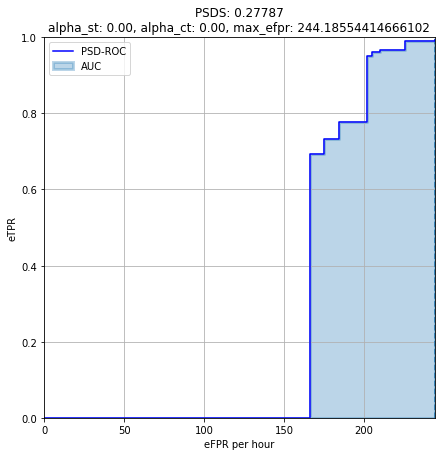

/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


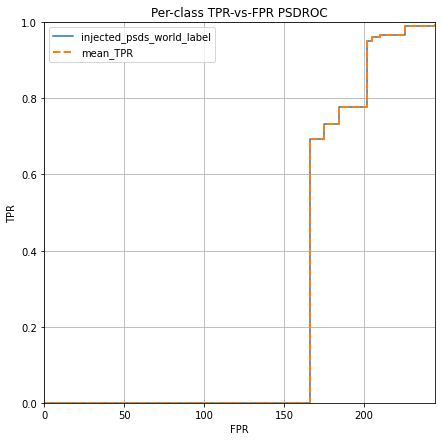

[  0.         166.16022696 174.71449762 184.30564956 201.93263152
 205.30249572 209.7092412  225.78090122 235.11283285 244.18554415]
[0.         0.69384215 0.73200347 0.77623591 0.95056375 0.96183868
 0.9670425  0.98959237 0.99132697 0.99219428]
ROC 127.63138635272819
ROC norm 0.522681990855573


In [51]:
do_eval('./data/predictions/dev/a', './data/labels/dev/a', filename = os.path.join(config.plot_dir, model_name + "_dev_a.png"))

In [ ]:
y_preds_all, y_test_A = evaluate_model(model, test_loader_A, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

In [ ]:
# Evaluate over dev B

In [28]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/b
!mkdir ../data/predictions/dev/b

In [31]:
evaluate_model_timestamp('.wav','../data/audio/dev/b','../data/predictions/dev/b', 2, 
                         model_weights_path=f'../models/{model_name}.pth',
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=False)

Evaluating model:


INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0650 seconds
Loaded model: ../models/VecNet_2020_06_14.pth
Processing: ../data/audio/dev/b for audio format: .wav
../data/audio/dev/b 222686.wav
dir_out ../data/predictions/dev/b filename 222686.wav
Processed: 222686.wav
../data/audio/dev/b 222713.wav
dir_out ../data/predictions/dev/b filename 222713.wav
Processed: 222713.wav
../data/audio/dev/b 222638.wav
Signal length too short, skipping: 0.399875 222638.wav
../data/audio/dev/b 199890.wav
dir_out ../data/predictions/dev/b filename 199890.wav
Processed: 199890.wav
../data/audio/dev/b 199929.wav
dir_out ../data/predictions/dev/b filename 199929.wav
Processed: 199929.wav
../data/audio/dev/b 222648.wav
dir_out ../data/predictions/dev/b filename 222648.wav
Processed: 222648.wav
../data/audio/dev/b 222659.wav
dir_out ../data/predictions/dev/b filename 222659.wav
Processed: 222659.wav
../data/audio/dev/b 

dir_out ../data/predictions/dev/b filename 199916.wav
Processed: 199916.wav
../data/audio/dev/b 199902.wav
dir_out ../data/predictions/dev/b filename 199902.wav
Processed: 199902.wav
../data/audio/dev/b 222707.wav
dir_out ../data/predictions/dev/b filename 222707.wav
Processed: 222707.wav
../data/audio/dev/b 222641.wav
dir_out ../data/predictions/dev/b filename 222641.wav
Processed: 222641.wav
../data/audio/dev/b 199913.wav
dir_out ../data/predictions/dev/b filename 199913.wav
Processed: 199913.wav
../data/audio/dev/b 199912.wav
dir_out ../data/predictions/dev/b filename 199912.wav
Processed: 199912.wav
../data/audio/dev/b 199942.wav
dir_out ../data/predictions/dev/b filename 199942.wav
Processed: 199942.wav
../data/audio/dev/b 199906.wav
dir_out ../data/predictions/dev/b filename 199906.wav
Processed: 199906.wav
../data/audio/dev/b 222665.wav
dir_out ../data/predictions/dev/b filename 222665.wav
Processed: 222665.wav
../data/audio/dev/b 222657.wav
dir_out ../data/predictions/dev/b fil

dir_out ../data/predictions/dev/b filename 222646.wav
Processed: 222646.wav
../data/audio/dev/b 222662.wav
dir_out ../data/predictions/dev/b filename 222662.wav
Processed: 222662.wav
Total files of .wav format processed: 157


debug [[ 68. 156.]
 [  0.   0.]] [0.95774648]

macro F-score: 46.10
debug [[ 65. 153.]
 [  0.   0.]] [0.91549296]

macro F-score: 44.98
debug [[ 62. 148.]
 [  0.   0.]] [0.87323944]

macro F-score: 44.13
debug [[ 59. 122.]
 [  0.   0.]] [0.83098592]

macro F-score: 46.83
debug [[ 56. 105.]
 [  0.   0.]] [0.78873239]

macro F-score: 48.28
debug [[53. 85.]
 [ 0.  0.]] [0.74647887]

macro F-score: 50.72
debug [[49. 74.]
 [ 0.  0.]] [0.69014085]

macro F-score: 50.52
debug [[43. 65.]
 [ 0.  0.]] [0.6056338]

macro F-score: 48.04
debug [[30. 75.]
 [ 0.  0.]] [0.42253521]

macro F-score: 34.09
debug [[0. 0.]
 [0. 0.]] [0.]

macro F-score: nan

PSD-Score: 0.44935


/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:810: RuntimeWarning: invalid value encountered in true_divide
  num_gts = per_class_tp / tp_ratios
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:820: RuntimeWarning: Mean of empty slice
  f_avg = np.nanmean(f_per_class)
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


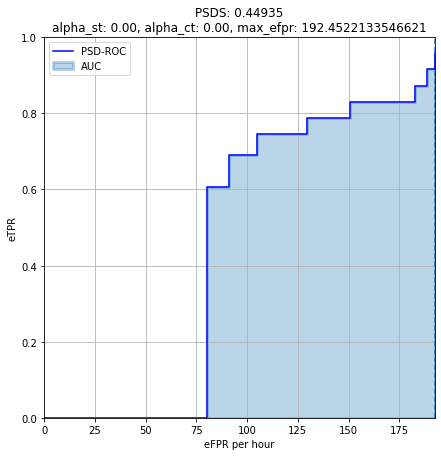

/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [32]:
do_eval('./data/predictions/dev/b', './data/labels/dev/b', filename = os.path.join(config.plot_dir, model_name + "_dev_b.png"))

Evaluating on cuda:0


  0%|          | 0/129 [00:00<?, ?it/s]

0.7187043351193375


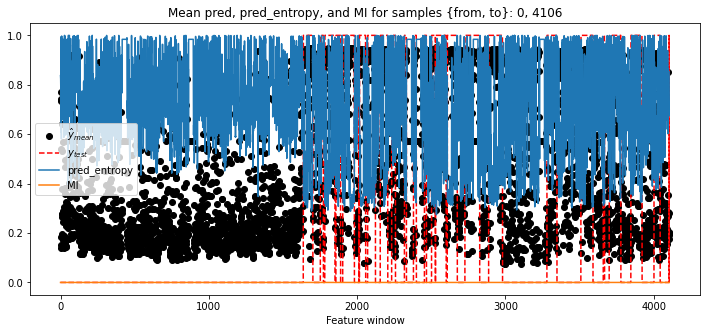

mean ROC AUC: 0.8093426547109868


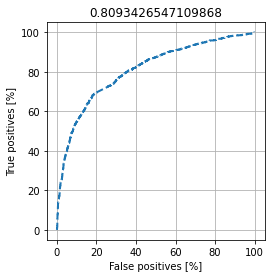

std ROC AUC: 0.0
PR-AUC:  0.6703788073594538


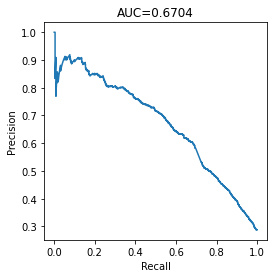

Confusion matrix, as input by user
[[70.735  29.265 ]
 [25.3175 74.6825]]


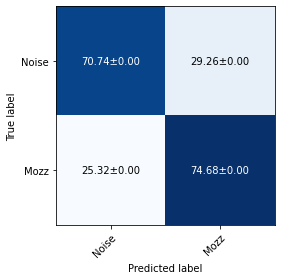

In [57]:
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')